# SkillupAI ML東京20期 通し課題 Day3_work_村井智哉

- データセット名  Kickstarter Projects
- URL https://www.kaggle.com/kemical/kickstarter-projects

## もくじ

1. ライブラリの読み込み  
2. データの読み込み  
3. データの確認  
  3.1 データ全体  
  3.2 目的変数の確認  
  3.3 欠測値を含む行の削除  
  3.4 各項目の内容と目的変数との関係  
4. 項目間の関係  
  4.1 main_categoryとcategoryの関係  
  4.2 currencyとcountryの関係  
  4.3 資金調達期間 period = deadline(締切日付) - launched(開始日時)  
  4.4 数値項目の相関関係  
5. 予測に用いる情報の編集  
  5.1 df_kspからの欠損値を含む行の削除  
  5.2 予測用df_ksp2の編集  
6. ロジスティック回帰  
  6.1 ホールドアウト法  
  6.2 交差検証法  
  6.3 特徴選択 (Lasso法)  
  6.4 特徴選択 (ラッパー法)  
  6.5 ホールドアウト法 (特徴選択後)  
7. SVM・線形カーネル 
8. SVM・ガウスカーネル  
9. 決定木  
  9.1 ホールドアウト法
  9.2 特徴選択 (ラッパー法)
  9.3 ホールドアウト法 (特徴選択後)  
10. ランダムフォレスト    
  10.1 ホールドアウト法
  10.2 特徴選択 (ラッパー法)
  10.3 ホールドアウト法 (特徴選択後)  
11. アダブースト  
  11.1 ホールドアウト法
  11.2 特徴選択 (ラッパー法)
  11.3 ホールドアウト法 (特徴選択後)  
12. 結果のまとめ

## 1. ライブラリの読み込み

In [1]:
# %matplotlib notebook
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt                                       # 日時を扱う

from sklearn.linear_model      import SGDClassifier
from sklearn.svm               import SVC
from sklearn.metrics           import log_loss, accuracy_score, \
        precision_score, recall_score, f1_score, confusion_matrix
                                                             # 分類問題の性能評価
from sklearn.linear_model      import LinearRegression      # 線形回帰
from sklearn.metrics           import mean_absolute_error   # 回帰問題における性能評価に関する関数
from sklearn.model_selection   import train_test_split      # ホールアウト法
from sklearn.model_selection   import KFold                 # 交差検証法
from sklearn.preprocessing     import MinMaxScaler          # 正規化
from sklearn.decomposition     import PCA                   # 主成分分析
from sklearn.preprocessing     import StandardScaler        # 標準化
from sklearn.feature_selection import SelectFromModel       # 
from sklearn.linear_model      import LassoCV               # Lasso
from sklearn.feature_selection import RFECV                 # 特徴選択

from sklearn.tree import DecisionTreeClassifier, export_graphviz    # 決定木
from sklearn.ensemble          import RandomForestClassifier        # ランダムフォレスト
from sklearn.ensemble          import AdaBoostClassifier            # アダブースト

## 2. データの読み込み

Kickstarter（キックスターター）とは2009年に設立されたアメリカ合衆国の民間営利企業で、自社のウェブサイトにおいてクリエイティブなプロジェクトに向けてクラウドファンディングによる資金調達を行う手段を提供している。

## (1) df_ksp(与えられた情報)

|項目            |種類|内容                             |検討結果                                                  |  
|----------------|----|---------------------------------|----------------------------------------------------------|  
|ID	             |key |プロジェクトのID                 |目的変数と関係がない➡予測には用いない                    |  
|name	         |文字|プロジェクト名                   |目的変数と関係がない➡予測には用いない                    |  
|category	     |文字|詳細なカテゴリー                 |98%のcategoryは1つのmain_categoryに属する➡予測に用いない |  
|main_category	 |文字|主なカテゴリー                   |予測に用いる◆                                            |  
|currency	     |通貨|使用された通貨                   |予測に用いる◆                                            |  
|deadline	     |日付|資金調達の締切日付               |予測に用いる◆                                            |  
|goal	         |数値|目標調達金額                     |米ドル以外の通貨と数値を比べられない可能性➡予測に用いない|  
|launched	     |日付|資金調達の開始日時               |予測には用いない                                          |  
|pledged	     |数値|集まった資金                     |調達結果➡予測に用いない                                  |  
|state	         |文字|プロジェクトの状態               |目的変数■                                                |  
|backers	     |数値|集まった支援者                   |調達結果➡予測に用いない                                  |  
|country	     |文字|資金調達を行う国                 |country毎に1つのcurrencyに属する➡予測に用いない          |  
|usd pledged	 |数値|調達金額の米ドル換算値           |調達結果➡予測に用いない                                  |  
|usd_pledged_real|数値|調達金額の米ドル換算値(REALとは?)|調達結果➡予測に用いない                                  |  
|usd_goal_real   |数値|目標調達金額の米ドル換算         |予測に用いる◆                                            |  

- 成功の定義：資金調達の開始日時から締切日までに目標調達資金額以上の金額を集めること。
- 課題：プロジェクトが成功するか否かを予測する。■目的変数はstate
- 注意：上記の▼調達結果は、プロジェクトが始まる前には知りえない値である。予測するためには使えない値である。

## (2) df_ksp2(予測に用いる情報)、df_ksp3(特徴量選択後の予測に用いる情報)

|項目            |種類|内容                                 |作成意図                          |  
|----------------|----|-------------------------------------|----------------------------------|  
|state	         |文字|プロジェクトの状態                   |目的変数■                        |  
|main_category	 |文字|主なカテゴリー                       |                                  |  
|currency	     |通貨|使用された通貨                       |                                  |  
|usd_goal_real   |数値|目標調達金額の米ドル換算             |                                  |  
|deadline_Ymf    |日付|deadlineの年月(年+月/12のfloat)      |                                  |
|period          |数値|deadline - launched (日数を示すfloat)|                                  |


In [2]:
df_ksp = pd.read_csv("./input/ks-projects-201801.csv")

In [3]:
df_ksp.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


## 3. データ各項目の確認

## 3.1 データ全体

In [4]:
# データ全体の行数、列数
print("df_ksp.shape=", df_ksp.shape)

df_ksp.shape= (378661, 15)


In [5]:
# 各項目の行数と型
df_ksp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
ID                  378661 non-null int64
name                378657 non-null object
category            378661 non-null object
main_category       378661 non-null object
currency            378661 non-null object
deadline            378661 non-null object
goal                378661 non-null float64
launched            378661 non-null object
pledged             378661 non-null float64
state               378661 non-null object
backers             378661 non-null int64
country             378661 non-null object
usd pledged         374864 non-null float64
usd_pledged_real    378661 non-null float64
usd_goal_real       378661 non-null float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


## 3.1.1 日時はobject➡datetimeに変換する(変換不可の場合はNA(欠損値)とする)

In [6]:
df_ksp["deadline"] = pd.to_datetime(df_ksp["deadline"], errors = "coerce")
df_ksp["launched"] = pd.to_datetime(df_ksp["launched"], errors = "coerce")

## 3.2 目的変数 state (状態)

|項目        |内容      |扱い    |値   |
|------------|----------|--------|-----|
|'suspended' |中断された|失敗    |False|  
|'live'      |生きている|使わない|     |
|'canceled'  |キャンセル|失敗    |False|
|'successful'|成功した  |成功    |True |
|'failed'    |失敗した  |失敗    |False|

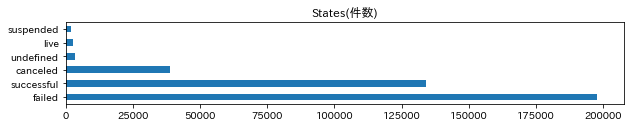

In [7]:
# 項目 state の概要確認
df_ksp["state"].value_counts().plot(kind="barh", figsize=(10,1.5), title="States(件数)")

In [8]:
df_ksp.loc[df_ksp["state"] == "suspended" , "state"] = False
df_ksp.loc[df_ksp["state"] == "live"      , "state"] = np.nan
df_ksp.loc[df_ksp["state"] == "canceled"  , "state"] = False
df_ksp.loc[df_ksp["state"] == "successful", "state"] = True
df_ksp.loc[df_ksp["state"] == "failed"    , "state"] = False

## 3.3 欠損値を含む行の削除
【対応】欠損値がある行は約1.7%と少ないため、行を削除する。

|項目       |件数  |割合                             |
|-----------|------|---------------------------------|
|name       |4件   |4÷378661=1.0563538362810007e-05 |
|state      |2799件|2799÷378861=0.007387933833252829|
|use pledged|3797件|3797÷378661=0.0100274387908974  |
|合計       |6600件|6600÷378861=0.017420637120210313|

In [9]:
# 各項目の欠損値
df_ksp.isnull().sum()

ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state               2799
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64

In [10]:
df_ksp = df_ksp.dropna(how="any")

In [11]:
df_ksp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 372062 entries, 0 to 378660
Data columns (total 15 columns):
ID                  372062 non-null int64
name                372062 non-null object
category            372062 non-null object
main_category       372062 non-null object
currency            372062 non-null object
deadline            372062 non-null datetime64[ns]
goal                372062 non-null float64
launched            372062 non-null datetime64[ns]
pledged             372062 non-null float64
state               372062 non-null object
backers             372062 non-null int64
country             372062 non-null object
usd pledged         372062 non-null float64
usd_pledged_real    372062 non-null float64
usd_goal_real       372062 non-null float64
dtypes: datetime64[ns](2), float64(5), int64(2), object(6)
memory usage: 45.4+ MB


In [12]:
# 各項目の欠損値
df_ksp.isnull().sum()

ID                  0
name                0
category            0
main_category       0
currency            0
deadline            0
goal                0
launched            0
pledged             0
state               0
backers             0
country             0
usd pledged         0
usd_pledged_real    0
usd_goal_real       0
dtype: int64

## 3.4 各項目

## 3.4.1 項目 ID
(1) 内容は、プロジェクト毎に付けたIDである。  
(2) IDはすべて異なるためstateとの関係は特にないと考える。このため、予測には用いない。

In [13]:
df_ksp["ID"].describe()

count    3.720620e+05
mean     1.074580e+09
std      6.191871e+08
min      5.971000e+03
25%      5.378083e+08
50%      1.075304e+09
75%      1.610135e+09
max      2.147476e+09
Name: ID, dtype: float64

In [14]:
# 項目 ID の概要確認
df_ksp["ID"].nunique()

372062

In [15]:
# 項目 ID の概要確認
df_ksp["ID"].unique()

array([1000002330, 1000003930, 1000004038, ...,  999986353,  999987933,
        999988282], dtype=int64)

## 3.4.2 項目 name
(1) 内容は、プロジェクト名である。  
(2) nameは369301種類あり、ほぼすべて異なるため、stateとの関係は、特にないと考える。このため、予測には用いない。

In [16]:
df_ksp["name"].describe()

count                  372062
unique                 369301
top       Canceled (Canceled)
freq                       13
Name: name, dtype: object

In [17]:
df_ksp["name"].unique()

array(['The Songs of Adelaide & Abullah',
       'Greeting From Earth: ZGAC Arts Capsule For ET', 'Where is Hank?',
       ...,
       'Walls of Remedy- New lesbian Romantic Comedy feature unlike any other!!',
       'BioDefense Education Kit', 'Nou Renmen Ayiti!  We Love Haiti!'],
      dtype=object)

## 3.4.3 項目 category (詳細なカテゴリー)
(1) 内容は、kickstarterプロジェクトの詳細なカテゴリーであり、159種類である。  
(2) category毎の件数は、最小が13件、最大が22073件と、約1700倍の違いがある。  
(3) category毎の成功率は、最小が24%、最大が57%と、約2.4倍の違いがある。

## 3.4.3.1 categoryの種類

In [18]:
df_ksp["category"].describe()

count             372062
unique               159
top       Product Design
freq               22073
Name: category, dtype: object

## 3.4.3.2 category毎の件数

In [19]:
df_ksp["category"].value_counts().min()

13

In [20]:
df_ksp["category"].value_counts().max()

22073

In [21]:
df_ksp["category"].value_counts().max()/df_ksp["category"].value_counts().min()

1697.923076923077

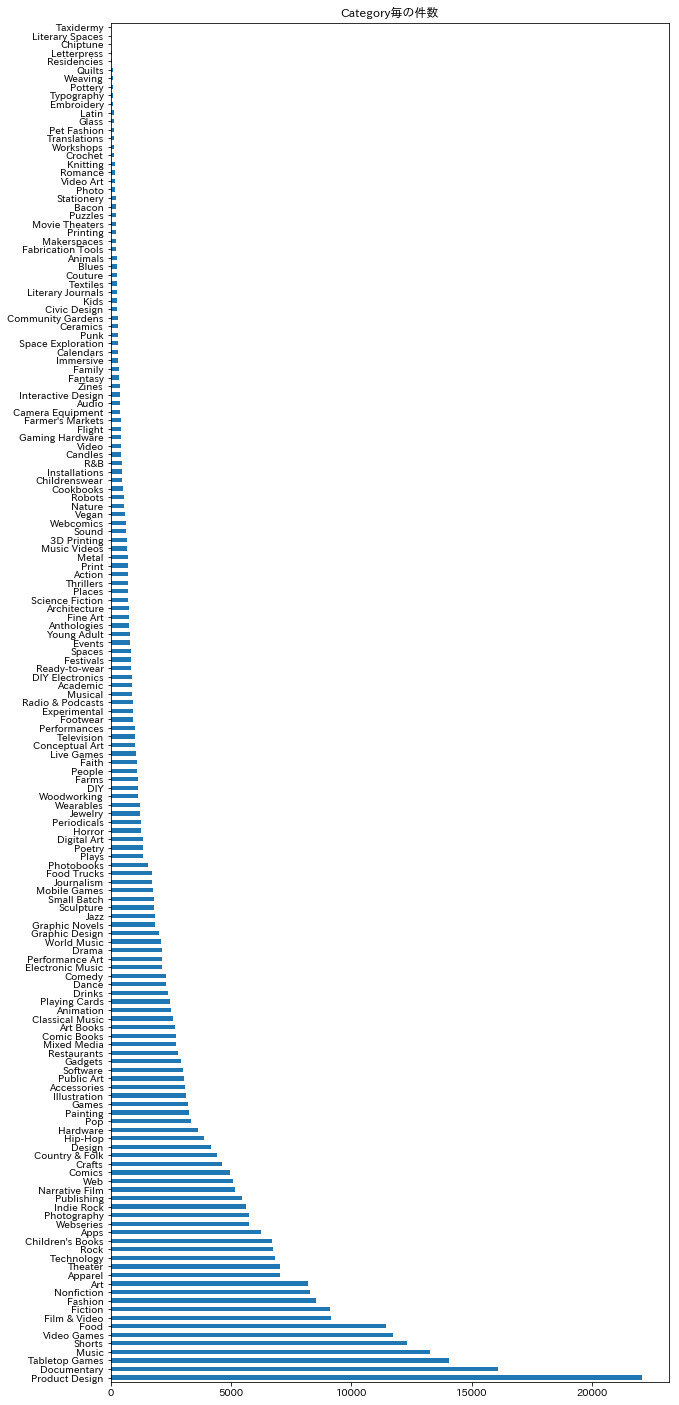

In [22]:
df_ksp["category"].value_counts().plot(kind="barh", figsize=(10,25), title="Category毎の件数")

## 3.4.3.3 category毎の成功率

In [23]:
successful = df_ksp.loc[df_ksp["state"]]
success_rate = pd.DataFrame(successful["category"].value_counts().values / df_ksp["category"].value_counts().values, 
                                     index=df_ksp["category"].value_counts().index, columns=["category"])

In [24]:
success_rate["category"].min()

0.2350230414746544

In [25]:
success_rate["category"].max()

0.5652173913043478

In [26]:
success_rate["category"].max()/success_rate["category"].min()

2.404944586530264

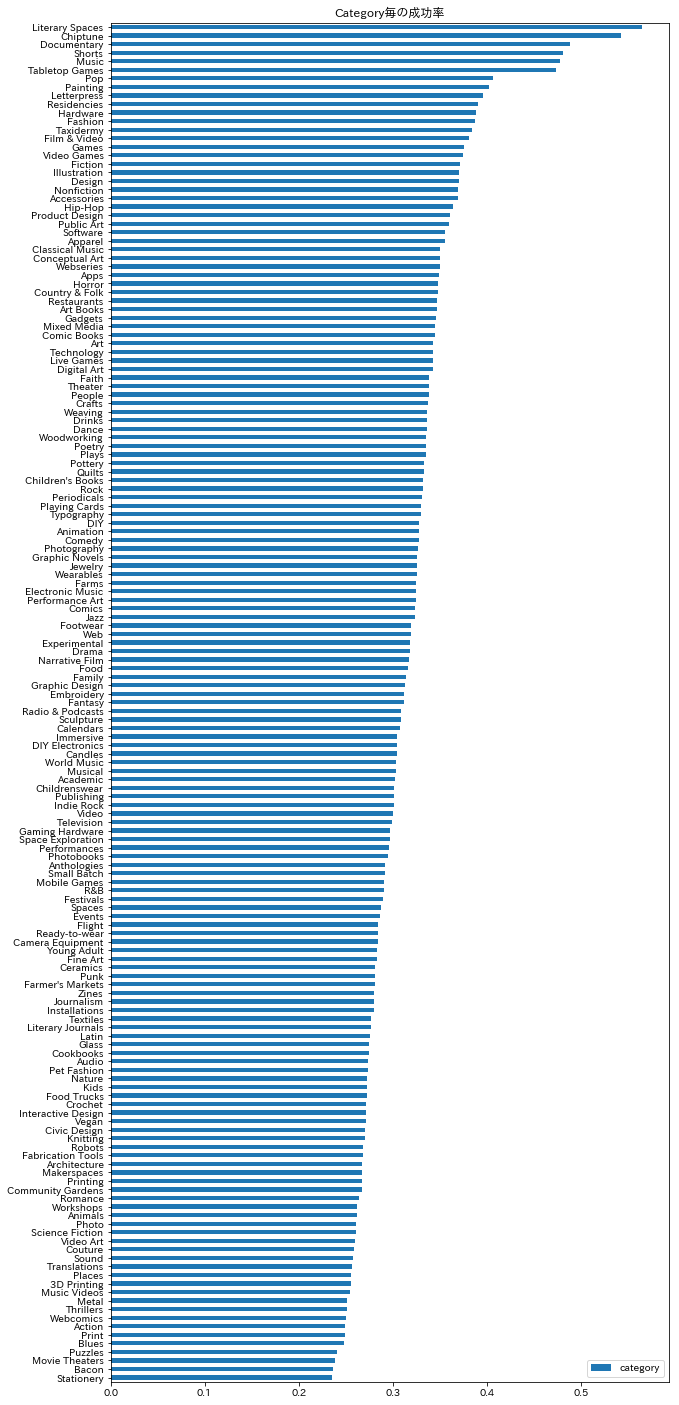

In [27]:
success_rate.sort_values(by="category").plot(kind="barh", figsize=(10,25), title="Category毎の成功率")

## 3.4.4 項目 main_category (主なカテゴリー)
(1) 内容は、kickstarterプロジェクトの主なカテゴリーであり、15種類である。  
(2) main_category毎の件数は、最小が3749件、最大が62364件と、約17倍の違いがある。   
(3) main_category毎の成功率は、最小が23%、最大が54%と、約2.3倍の違いがある。

## 3.4.4.1 main_categoryの種類

In [28]:
df_ksp["main_category"].describe()

count           372062
unique              15
top       Film & Video
freq             62364
Name: main_category, dtype: object

## 3.4.4.2 main_category毎の件数

In [29]:
df_ksp["main_category"].value_counts().min()

3749

In [30]:
df_ksp["main_category"].value_counts().max()

62364

In [31]:
df_ksp["main_category"].value_counts().max()/df_ksp["main_category"].value_counts().min()

16.634835956255003

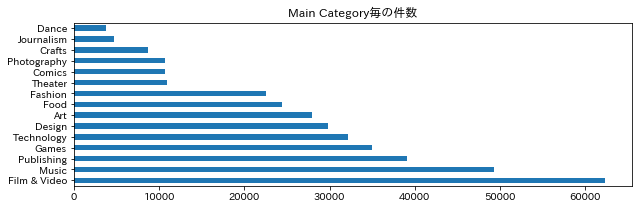

In [32]:
df_ksp["main_category"].value_counts().plot(kind="barh", figsize=(10,3), title="Main Category毎の件数")

## 3.4.4.3 main_category毎の成功率

In [33]:
successful = df_ksp.loc[df_ksp["state"]]
success_rate = pd.DataFrame(successful["main_category"].value_counts().values / df_ksp["main_category"].value_counts().values, 
                                     index=df_ksp["main_category"].value_counts().index, columns=["main_category"])

In [34]:
success_rate["main_category"].min()

0.2337077044137635

In [35]:
success_rate["main_category"].max()

0.5373930641155368

In [36]:
success_rate["main_category"].max()/success_rate["main_category"].min()

2.299423827141441

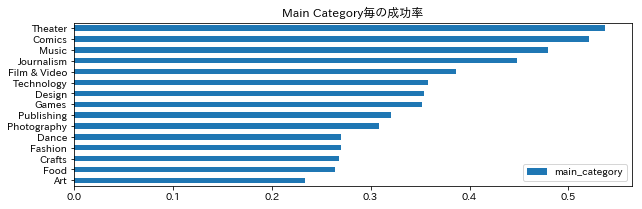

In [37]:
success_rate.sort_values(by="main_category").plot(kind="barh", figsize=(10,3), title="Main Category毎の成功率")

## 3.4.5 項目 currency (使用された通貨)
(1) 内容は、プロジェクトが使用する通貨であり、14種類がある。  
(2) currency毎の件数は、最小が31件(日本円)、最大が290884件(米ドル)と、約9400倍の違いがある。  
(3) currency毎の成功率は、最小が23%(日本円)、最大が38%(米ドル)と、約1.7倍の違いがある。  

## 3.4.5.1 currencyの種類

In [38]:
df_ksp["currency"].describe()

count     372062
unique        14
top          USD
freq      290884
Name: currency, dtype: object

## 3.4.5.2 currency毎の件数

In [39]:
df_ksp["currency"].value_counts().min()

31

In [40]:
df_ksp["currency"].value_counts().max()

290884

In [41]:
df_ksp["currency"].value_counts().max() / df_ksp["currency"].value_counts().min()

9383.354838709678

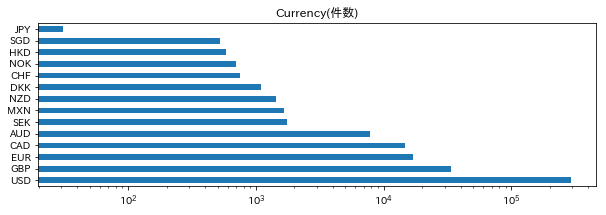

In [42]:
df_ksp["currency"].value_counts().plot(kind="barh", figsize=(10,3), logx=True, title="Currency(件数)")

## 3.4.5.3 currency毎の成功率

In [43]:
successful = df_ksp.loc[df_ksp["state"]]
success_rate = pd.DataFrame(successful["currency"].value_counts().values / df_ksp["currency"].value_counts().values, 
                                     index=df_ksp["currency"].value_counts().index, columns=["currency"])

In [44]:
success_rate["currency"].min()

0.22580645161290322

In [45]:
success_rate["currency"].max()

0.3757477207409139

In [46]:
success_rate["currency"].max()/success_rate["currency"].min()

1.6640256204240473

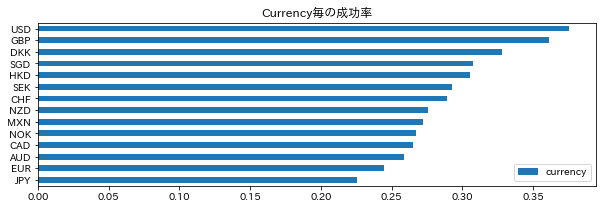

In [47]:
success_rate.sort_values(by="currency").plot(kind="barh", figsize=(10,3), title="Currency毎の成功率")

## 3.4.6 項目 deadline (資金調達の締切日付)
(1) 内容は、kickstarterプロジェクトの締切の日付である。

(2) deadlineの日付は、最古値が2009年5月3日、最新値が2018年2月24日である。

(3) deadlineを年毎にまとめた件数は、以下となっている。  
  - 2009年から2015年は、件数がほぼ毎年増えている。(例外は2013年)  
  - 2015年から2017年は、件数が毎年減っている。
  - 2018年は、2月までしかデータがないため、件数の比較ができない。  
  
(4) deadlineを年毎にまとめた成功率は、以下となっている。  
  - 件数が少ない2009年と2018年を除いて考える。  
  - 成功率が極端に高い2014年を除いて考える。  
  - 成功率は、ほぼ毎年増えている。  

(5) deadlineを年月毎にまとめた件数は、以下となっている。  
  - 件数が少ない2009年と2018年を除いて考える。  
  - 件数が極端に多い2014年08月を除いて考える。  
  - 1年毎の件数が最も多い月は、3月～9月である。  

|年     |件数が最も多い月 |  
|-------|-----------------|  
|2010年 |07月             |  
|2011年 |08月             |  
|2012年 |05月             |  
|2013年 |07月             |  
|2014年 |09月             |  
|2015年 |04月             |  
|2016年 |03月             |  
|2017年 |03月             |  

(6) deadlineを年月毎にまとめた成功率は、以下となっている。  
  - 件数が少ない2009年と2018年を除いて考える。 
  - 成功率が極端に高い2014年08月を除いて考える。  
  - 1年毎の成功率が最も高い月は、10月～12月である。  

|年     |成功率が最も多い月 |  
|-------|-------------------|  
|2010年 |12月               |  
|2011年 |11月               |  
|2012年 |02月               |  
|2013年 |12月               |  
|2014年 |10月               |  
|2015年 |11月               |  
|2016年 |10月               |  
|2017年 |12月               |  

## 3.4.6.1 deadlineの種類

In [48]:
df_ksp["deadline"].describe()

count                  372062
unique                   3149
top       2014-08-08 00:00:00
freq                      702
first     2009-05-03 00:00:00
last      2018-02-24 00:00:00
Name: deadline, dtype: object

In [49]:
df_ksp["deadline_Y"]  = df_ksp["deadline"].dt.strftime("%Y")
df_ksp["deadline_m"]  = df_ksp["deadline"].dt.strftime("%m")
df_ksp["deadline_Ym"] = df_ksp["deadline"].dt.strftime("%Y-%m")
df_ksp["count"]=1

In [50]:
df_ksp["deadline_Ymf"] = df_ksp["deadline"].dt.strftime("%Y").astype(float) + \
                         df_ksp["deadline"].dt.strftime("%m").astype(float) / 12

In [51]:
df_ksp.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,deadline_Y,deadline_m,deadline_Ym,count,deadline_Ymf
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,False,0,GB,0.0,0.0,1533.95,2015,10,2015-10,1,2015.833333
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,False,15,US,100.0,2421.0,30000.00,2017,11,2017-11,1,2017.916667
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,False,3,US,220.0,220.0,45000.00,2013,02,2013-02,1,2013.166667
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,False,1,US,1.0,1.0,5000.00,2012,04,2012-04,1,2012.333333
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,False,14,US,1283.0,1283.0,19500.00,2015,08,2015-08,1,2015.666667


## 3.4.6.2 deadlineの年毎の件数

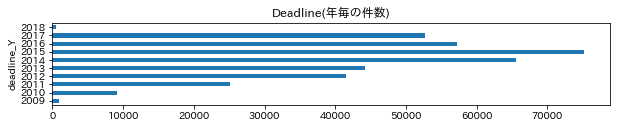

In [52]:
df_ksp.groupby(["deadline_Y"]).sum()["count"].plot(kind="barh", figsize=(10,1.5), title="Deadline(年毎の件数)")

## 3.4.6.3 deadlineの年毎の成功率

In [53]:
successful = df_ksp.loc[df_ksp["state"]]
success_count = successful.groupby(["deadline_Y"]).sum()["count"]
all_count = df_ksp.groupby(["deadline_Y"]).sum()["count"]
success_rate = pd.DataFrame(success_count / all_count)

In [54]:
success_rate["count"].min()

0.17916666666666667

In [55]:
success_rate["count"].max()

0.4687325738867203

In [56]:
success_rate["count"].max() / success_rate["count"].min()

2.616181807739834

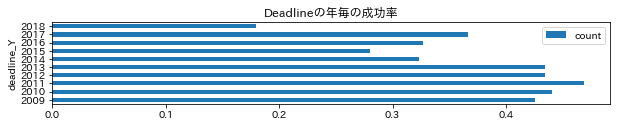

In [57]:
success_rate.plot(kind="barh", figsize=(10,1.5), title="Deadlineの年毎の成功率")

## 3.4.6.4 deadlineの年月毎の件数

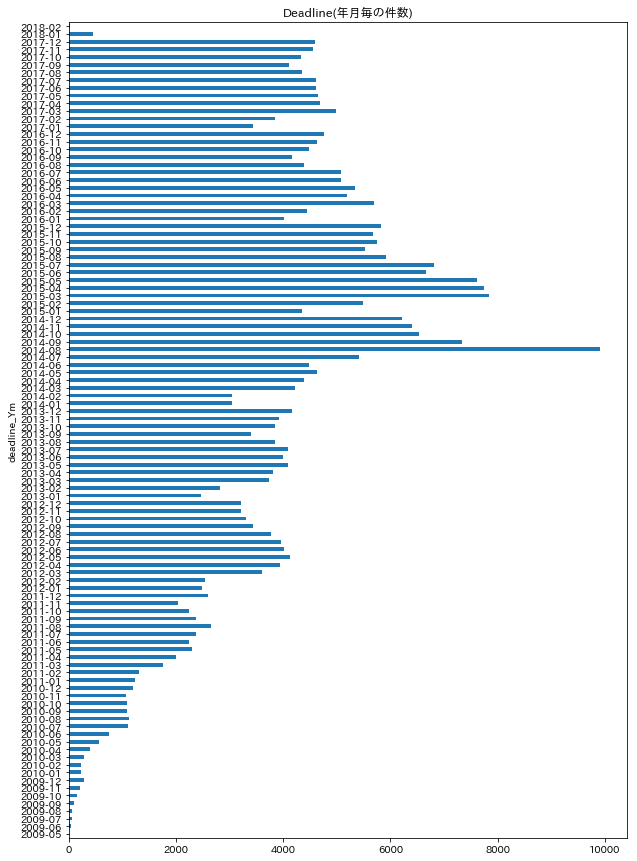

In [58]:
df_ksp.groupby(["deadline_Ym"]).sum()["count"].plot(kind="barh", figsize=(10,15), title="Deadline(年月毎の件数)")

## 3.4.6.5 deadlineの年月毎の成功率

In [59]:
successful = df_ksp.loc[df_ksp["state"]]
success_count = successful.groupby(["deadline_Ym"]).sum()["count"]
all_count = df_ksp.groupby(["deadline_Ym"]).sum()["count"]
success_rate = pd.DataFrame(success_count / all_count)

In [60]:
success_rate["count"].min()

0.18984547461368653

In [61]:
success_rate["count"].max()

0.5588235294117647

In [62]:
success_rate["count"].max() / success_rate["count"].min()

2.9435704514363885

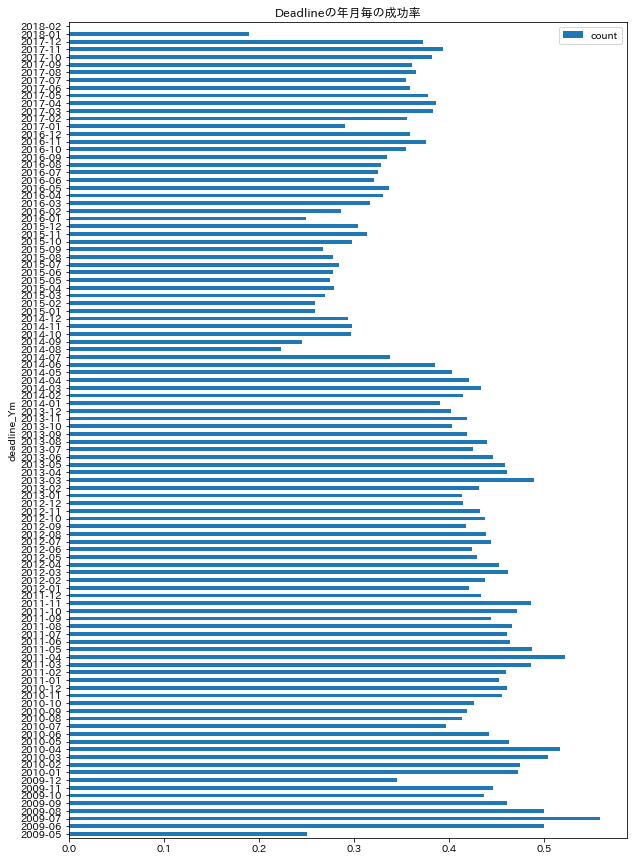

In [63]:
success_rate.plot(kind="barh", figsize=(10,15), title="Deadlineの年月毎の成功率")

## 3.4.7 項目 goal (目標調達金額)
(1) 内容は、kickstarterプロジェクトの目標調達金額である。  
(2) goalの値は、最小値が0.01、最大値が10e8と、10e10という極端に大きな値である。なお、中央値は5,500、75%値は1.65e4である。  
(3) 外れ値を除外したところ、最大値は25500となった。  
(4) 金額の単位がcurrencyとなっていて、異なるcurrency間での比較ができない可能性がある。確認が必要。

## 3.4.7.1 goalの分布確認

In [64]:
df_ksp["goal"].describe()

count    3.720620e+05
mean     4.931800e+04
std      1.182574e+06
min      1.000000e-02
25%      2.000000e+03
50%      5.500000e+03
75%      1.650000e+04
max      1.000000e+08
Name: goal, dtype: float64

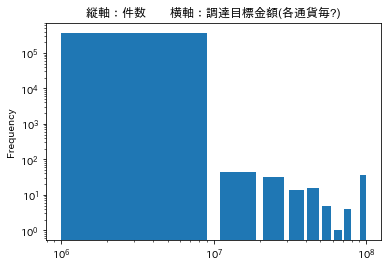

In [65]:
df_ksp["goal"].plot(kind="hist", rwidth=.8, logx=True, logy=True, title="縦軸：件数　　横軸：調達目標金額(各通貨毎?)")

## 3.4.8 項目 launched (資金調達の開始日時)  
(1) 内容は、kickstarterプロジェクトの資金調達の開始日時である。  

(2) launchedの日付は、最古値が1970年1月1日で、最新値が2018年1月2日である。  

(3) launchedの最古値は、日付が入らなかったためと考え、外れ値として除外した。最古値は2009年4月21日になった。  

(4) 外れ値除外後のlaunchedを年毎にまとめた件数は、以下となっている。  
  - 2009年から2015年までは、件数が毎年増えている。  
  - 2015年と2016年は、件数がほぼ同じである。  
  - 2016年から2018年は、件数が毎年減っている。  
  
(3) 成功したプロジェクトにおけるdeadlineを年毎にまとめて件数は、以下となっている。  
  - 2009年から2012年まで毎年増えており、2012年から2018年はほぼ一定である。  

(4) DateFrameにて年毎の件数を取り出す方法がわからなかった。  
  - 成功率を計算することができなかった。  

## 3.4.8.1 launchedの種類

In [66]:
df_ksp["launched"].describe()

count                  372062
unique                 371503
top       1970-01-01 01:00:00
freq                        7
first     1970-01-01 01:00:00
last      2018-01-02 03:05:10
Name: launched, dtype: object

In [67]:
df_ksp["launched_Y"]  = df_ksp["launched"].dt.strftime("%Y")
df_ksp["launched_m"]  = df_ksp["launched"].dt.strftime("%m")
df_ksp["launched_Ym"] = df_ksp["launched"].dt.strftime("%Y-%m")
df_ksp["count"]=1

In [68]:
df_ksp["launched_Ymf"] = df_ksp["launched"].dt.strftime("%Y").astype(float) + \
                         df_ksp["launched"].dt.strftime("%m").astype(float) / 12

In [69]:
df_ksp.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,...,usd_goal_real,deadline_Y,deadline_m,deadline_Ym,count,deadline_Ymf,launched_Y,launched_m,launched_Ym,launched_Ymf
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,False,...,1533.95,2015,10,2015-10,1,2015.833333,2015,08,2015-08,2015.666667
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,False,...,30000.00,2017,11,2017-11,1,2017.916667,2017,09,2017-09,2017.750000
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,False,...,45000.00,2013,02,2013-02,1,2013.166667,2013,01,2013-01,2013.083333
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,False,...,5000.00,2012,04,2012-04,1,2012.333333,2012,03,2012-03,2012.250000
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,False,...,19500.00,2015,08,2015-08,1,2015.666667,2015,07,2015-07,2015.583333


## 3.4.8.2 launchedの年毎の件数

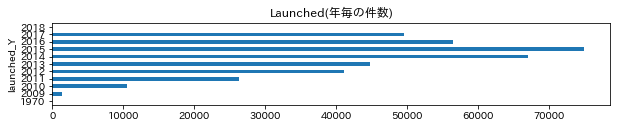

In [70]:
df_ksp.groupby(["launched_Y"]).sum()["count"].plot(kind="barh", figsize=(10,1.5), title="Launched(年毎の件数)")

## 3.4.8.3 launchedの外れ値の除去
- launchedから1970-01-01を取り除く

In [71]:
df_ksp = df_ksp[df_ksp["launched"] > dt.datetime(1970, 1, 2)]

In [72]:
df_ksp["launched"].describe()

count                  372055
unique                 371502
top       2014-04-25 20:16:26
freq                        2
first     2009-04-21 21:02:48
last      2018-01-02 03:05:10
Name: launched, dtype: object

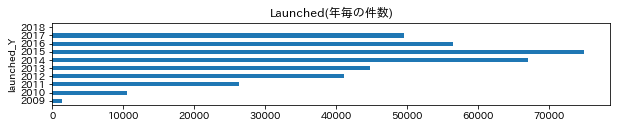

In [73]:
df_ksp.groupby(["launched_Y"]).sum()["count"].plot(kind="barh", figsize=(10,1.5), title="Launched(年毎の件数)")

## 3.4.8.4 launchedの年毎の成功率

In [74]:
successful = df_ksp.loc[df_ksp["state"]]
success_count = successful.groupby(["deadline_Y"]).sum()["count"]
all_count = df_ksp.groupby(["deadline_Y"]).sum()["count"]
success_rate = pd.DataFrame(success_count / all_count)

In [75]:
success_rate["count"].min()

0.17916666666666667

In [76]:
success_rate["count"].max()

0.4687325738867203

In [77]:
success_rate["count"].max() / success_rate["count"].min()

2.616181807739834

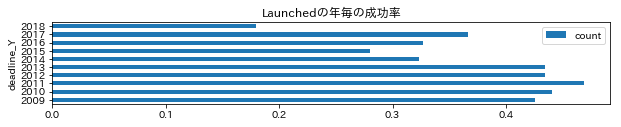

In [78]:
success_rate.plot(kind="barh", figsize=(10,1.5), title="Launchedの年毎の成功率")

## 3.4.8.5 launchedの年月毎の件数

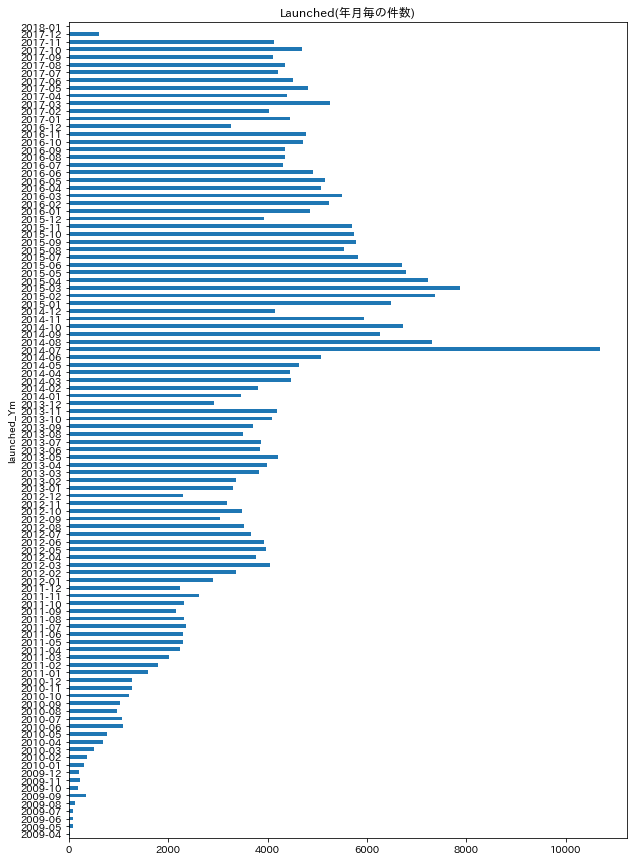

In [79]:
df_ksp.groupby(["launched_Ym"]).sum()["count"].plot(kind="barh", figsize=(10,15), title="Launched(年月毎の件数)")

## 3.4.8.6 launchedの年月毎の成功率

In [80]:
successful = df_ksp.loc[df_ksp["state"]]
success_count = successful.groupby(["launched_Ym"]).sum()["count"]
all_count = df_ksp.groupby(["launched_Ym"]).sum()["count"]
success_rate = pd.DataFrame(success_count / all_count)

In [81]:
success_rate["count"].min()

0.21103319308087892

In [82]:
success_rate["count"].max()

0.5789473684210527

In [83]:
success_rate["count"].max() / success_rate["count"].min()

2.7433948184595294

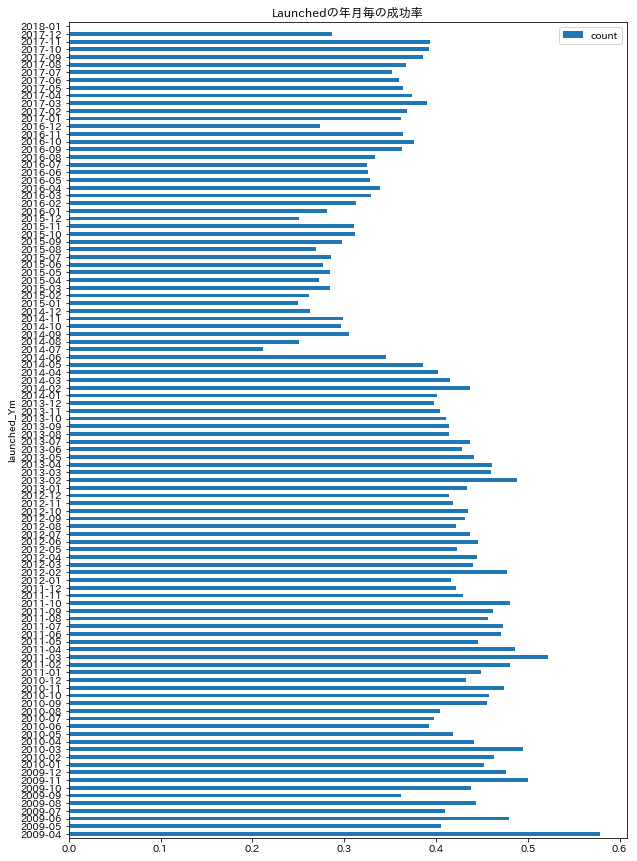

In [84]:
success_rate.plot(kind="barh", figsize=(10,15), title="Launchedの年月毎の成功率")

## 3.4.9 項目 pledged (集まった金額)
(1) 内容は、集まった金額である。  
(2) pledgedの値は、最小値が0、最大値が9.2e6という極端に大きな値である。なお、25%値は36、中央値は615、75%値は3586である。  
(3) 外れ値を除外したところ、最大値は3350.35となった(なぜ小数点化があるのか?)。25%値は10、中央値は175、75%値は985である。  
(4) 金額の単位がcurrencyとなっていて、異なるcurrency間での比較ができない可能性がある。確認が必要。 
(5) "-ed"とあるため、プロジェクトが完了してから確定する数値であり、プロジェクトの成功するか否かの予測には使えない。

## 3.4.9.1 pledgedの分布確認

In [85]:
df_ksp["pledged"].describe()

count    3.720550e+05
mean     9.755701e+03
std      9.626656e+04
min      0.000000e+00
25%      3.100000e+01
50%      6.250000e+02
75%      4.093000e+03
max      2.033899e+07
Name: pledged, dtype: float64

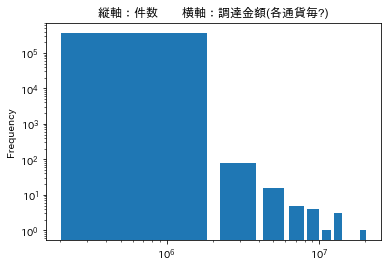

In [86]:
df_ksp["pledged"].plot(kind="hist", rwidth=.8, logx=True, logy=True, title="縦軸：件数　　横軸：調達金額(各通貨毎?)")

## 3.4.10 項目 backers (集まった支援者)
(1) 内容は、集まった支援者の人数である。  
(2) backersの値は、最小値が0、最大値が219382という極端に大きな値である。なお、25%値は2、中央値は13、75%値は55である。  
(3) 外れ値を除外したところ、最大値は70となった。25%値は1、中央値は6、75%値は24である。   
(4) プロジェクトが完了してから確定する数値であり、プロジェクトの成功するか否かの予測には使えない。

## 3.4.10.1 backersの分布確認

In [87]:
df_ksp["backers"].describe()

count    372055.000000
mean        106.980393
std         914.532666
min           0.000000
25%           2.000000
50%          12.000000
75%          57.000000
max      219382.000000
Name: backers, dtype: float64

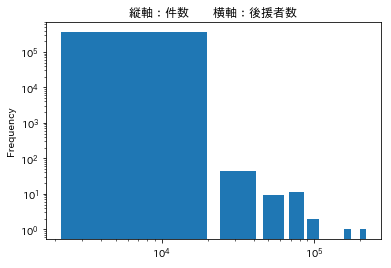

In [88]:
df_ksp["backers"].plot(kind="hist", rwidth=.8, logx=True, logy=True, title="縦軸：件数　　横軸：後援者数")

## 3.4.11 項目 country (プロジェクトが開かれた国)
(1) 内容は、kickstarterプロジェクトが開かれた国であり、21種類である。  
(2) country毎の件数は、最小が37件(ルクセンブルグ)、最大が193983件(米国)と、約5200倍の違いがある。  
(3) country毎の成功率は、最小が12%(フランス)、最大が31%(アイルランド)と、約2.6倍の違いがある。  

## 3.4.11.1 countryの種類

In [89]:
df_ksp["country"].describe()

count     372055
unique        22
top           US
freq      290878
Name: country, dtype: object

## 3.4.11.2 country毎の件数

In [90]:
df_ksp["country"].value_counts().min()

31

In [91]:
df_ksp["country"].value_counts().max()

290878

In [92]:
df_ksp["country"].value_counts().max() / df_ksp["country"].value_counts().min()

9383.161290322581

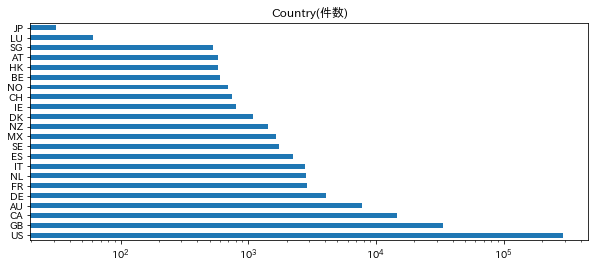

In [93]:
df_ksp["country"].value_counts().plot(kind="barh", figsize=(10,4), logx=True, title="Country(件数)")

## 3.4.11.3 country毎の成功率

In [94]:
successful = df_ksp.loc[df_ksp["state"]]
success_rate = pd.DataFrame(successful["country"].value_counts().values / df_ksp["country"].value_counts().values, 
                                     index=df_ksp["country"].value_counts().index, columns=["country"])

In [95]:
success_rate["country"].min()

0.18165596002855103

In [96]:
success_rate["country"].max()

0.37575547136600224

In [97]:
success_rate["country"].max() / success_rate["country"].min()

2.0685006498379925

In [98]:
success_rate = pd.DataFrame(successful["country"].value_counts().values / df_ksp["country"].value_counts().values, 
                                     index=df_ksp["country"].value_counts().index, columns=["country"])

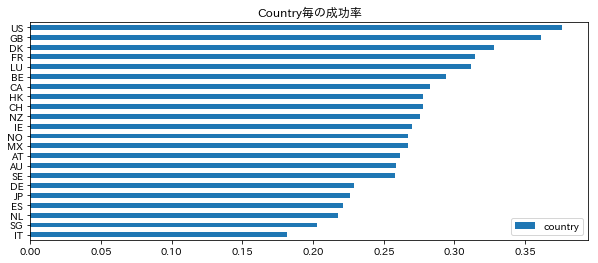

In [99]:
success_rate.sort_values(by="country").plot(kind="barh", figsize=(10,4), title="Country毎の成功率")

## 3.4.12 項目 usd pledged (調達金額の米ドル換算値)
(1) 内容は、集まった金額を米ドルに換算した値である。  
(2) usd pledgedの値は、最小値が0、最大値が158791という極端に大きな値である。なお、25%値は4.58、中央値は155、75%値は1051である。  
(3) 外れ値を除外したところ、最大値は844.36となった。25%値は0、中央値は38、75%値は217である。  
(4) "-ed"とあるため、プロジェクトが完了してから確定する数値であり、プロジェクトの成功するか否かの予測には使えない。

## 3.4.12.1 usd pledgedの分布確認

In [100]:
df_ksp["usd pledged"].describe()

count    3.720550e+05
mean     7.080423e+03
std      7.893221e+04
min      0.000000e+00
25%      1.800000e+01
50%      4.000000e+02
75%      3.057000e+03
max      2.033899e+07
Name: usd pledged, dtype: float64

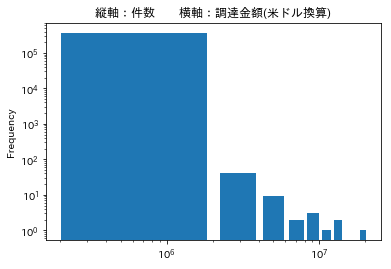

In [101]:
df_ksp["usd pledged"].plot(kind="hist", rwidth=.8, logx=True, logy=True, title="縦軸：件数　　横軸：調達金額(米ドル換算)")

## 3.4.13 項目 usd_pledged_real (調達金額の米ドル換算値・ところでREALとは?)
(1) 内容は、集まった金額を米ドルに換算した値である。なお、usd pledgedとの区別が不明である。  
(2) usd_pledged_realの値は、最小値が0、最大値が4141.35である。なお、25%値は0、中央値は25、75%値は114である。  
(3) 外れ値を除外したところ、最大値は136.18となった。25%値は0、中央値は20.53、75%値は101である。  
(4) "-ed"とあるため、プロジェクトが完了してから確定する数値であり、プロジェクトの成功するか否かの予測には使えない。

## 3.4.13.1 usd_pledged_realの分布確認

In [102]:
df_ksp["usd_pledged_real"].describe()

count    3.720550e+05
mean     9.145509e+03
std      9.162231e+04
min      0.000000e+00
25%      3.125000e+01
50%      6.279700e+02
75%      4.066000e+03
max      2.033899e+07
Name: usd_pledged_real, dtype: float64

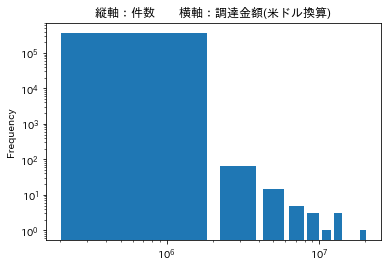

In [103]:
# 項目 usd_pledged_real の概要確認
df_ksp["usd_pledged_real"].plot(kind="hist", rwidth=.8, logx=True, logy=True, title="縦軸：件数　　横軸：調達金額(米ドル換算)")

## 3.4.13.3 成功したプロジェクトの調達金額の米ドル換算値

In [104]:
successful = df_ksp.loc[df_ksp["state"]]

In [105]:
successful["usd_pledged_real"].describe()

count    1.338510e+05
mean     2.266449e+04
std      1.509631e+05
min      7.900000e-01
25%      2.000000e+03
50%      5.109000e+03
75%      1.324147e+04
max      2.033899e+07
Name: usd_pledged_real, dtype: float64

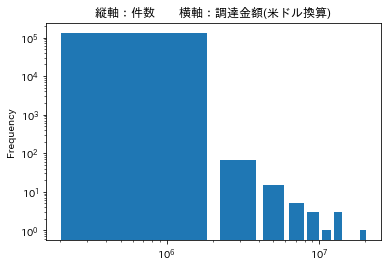

In [106]:
successful["usd_pledged_real"].plot(kind="hist", rwidth=0.8, logx=True, logy=True, title="縦軸：件数　　横軸：調達金額(米ドル換算)")

## 3.4.13.4 失敗したプロジェクトの調達金額の米ドル換算値
- 失敗したプロジェクトの調達金額は、最小値と25%値が$0、50%値が$5、75%値が$44、最大値が$136.18であった。

In [107]:
failed = df_ksp.loc[((df_ksp["state"].astype(int) - 1)*(-1)).astype(bool)]

In [108]:
failed["usd_pledged_real"].describe()

count    2.382040e+05
mean     1.548959e+03
std      1.205775e+04
min      0.000000e+00
25%      1.200000e+00
50%      1.000000e+02
75%      6.970000e+02
max      4.005111e+06
Name: usd_pledged_real, dtype: float64

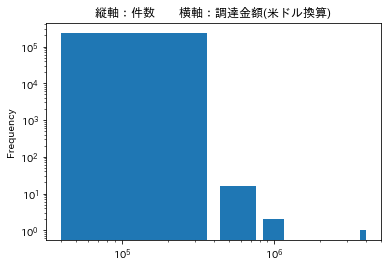

In [109]:
failed["usd_pledged_real"].plot(kind="hist", rwidth=.8, logx=True, logy=True, title="縦軸：件数　　横軸：調達金額(米ドル換算)")

## 3.4.14 項目 usd_goal_real (目標調達金額の米ドル換算)  
(1) 内容は、目標調達金額を米ドルに換算した値である。usd pledgedとの区別が不明である。  

(2) usd_goal_realの値は、最小値が1.0e-2、最大値が1.7e+8という極端に値に幅がある。

(3) usd_goal_real標準化後の値は、最小値が-0.04、最大値が144であった。

(4) 成功したプロジェクトの標準化後の値は、最小値が-0.04、最大値が1.7であった。
  - 標準化後の値が1.7～144は、すべて失敗しており、高額目標金額を成功させることは難しいことがわかる。

(5) 成功したプロジェクトのusd_goal_realの値は、最小値が1.0e-2、最大値が2.0e+6であった。

(6) 以下の理由から、プロジェクトが成功するか否かを予測するために使うことができる値と考える。  
  - プロジェクトが資金調達を始める前に確定する数値である。  
  - 米ドル換算値であるため、通貨(currency)が異なっても比較することができる値である。  
  - 元の値は極端に幅が広いため、予測には標準化後の値を用いることにする。

## 3.4.14.1 usd_goal_realの分布確認

In [110]:
df_ksp["usd_goal_real"].describe()

count    3.720550e+05
mean     4.573831e+04
std      1.151699e+06
min      1.000000e-02
25%      2.000000e+03
50%      5.500000e+03
75%      1.600000e+04
max      1.663614e+08
Name: usd_goal_real, dtype: float64

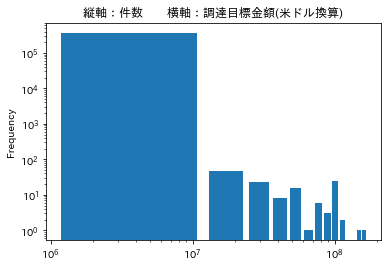

In [111]:
df_ksp["usd_goal_real"].plot(kind="hist", rwidth=.8, logx=True, logy=True, bins=14,
                             title="縦軸：件数　　横軸：調達目標金額(米ドル換算)")

In [112]:
df_ksp[df_ksp["usd_goal_real"] > 1e8]

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,...,usd_goal_real,deadline_Y,deadline_m,deadline_Ym,count,deadline_Ymf,launched_Y,launched_m,launched_Ym,launched_Ymf
47803,1243678698,FUCK Potato Salad. Paleo Potato Brownies!,Food,Food,GBP,2014-08-08,99000000.0,2014-07-09 00:24:34,0.0,False,...,1.663614e+08,2014,08,2014-08,1,2014.666667,2014,07,2014-07,2014.583333
196531,2000749004,A Celtic Lovestory,Drama,Film & Video,GBP,2015-11-30,100000000.0,2015-11-17 00:47:15,0.0,False,...,1.513959e+08,2015,11,2015-11,1,2015.916667,2015,11,2015-11,2015.916667
222208,2132015082,DER NEANDERTALER (Kinofilm mit Starbesetzung i...,Movie Theaters,Film & Video,EUR,2017-03-14,100000000.0,2017-01-13 20:08:41,36.0,False,...,1.073699e+08,2017,03,2017-03,1,2017.250000,2017,01,2017-01,2017.083333
226161,219702078,Kitchen from Austria in Switzerland,Restaurants,Food,CHF,2015-10-05,100000000.0,2015-08-06 19:12:10,0.0,False,...,1.040572e+08,2015,10,2015-10,1,2015.833333,2015,08,2015-08,2015.666667
367928,944541075,Hydroponic's Skyscraper(un gratte-ciel hydropo...,Technology,Technology,EUR,2015-10-24,100000000.0,2015-08-25 23:52:30,2.0,False,...,1.101698e+08,2015,10,2015-10,1,2015.833333,2015,08,2015-08,2015.666667


## 3.4.14.2 usd_goal_realを標準化する➡usd_goal_real_std
(1) usd_goal_realの範囲が1e-2～1e8と広いため、標準化して数値の範囲を狭める。
(2) mean=45738、var=1.3264e12

In [113]:
stdsc = StandardScaler()
df_ksp["usd_goal_real_std"] = stdsc.fit_transform(df_ksp[["usd_goal_real"]].values)
usd_goal_real_std = pd.DataFrame(stdsc.mean_, columns=["mean"])
usd_goal_real_std["var"] = stdsc.var_

In [114]:
usd_goal_real_std

,mean,var
0,45738.306322,1.326407e+12


In [115]:
df_ksp["usd_goal_real_std"].describe()

count    3.720550e+05
mean     4.423048e-17
std      1.000001e+00
min     -3.971381e-02
25%     -3.797725e-02
50%     -3.493826e-02
75%     -2.582128e-02
max      1.444091e+02
Name: usd_goal_real_std, dtype: float64

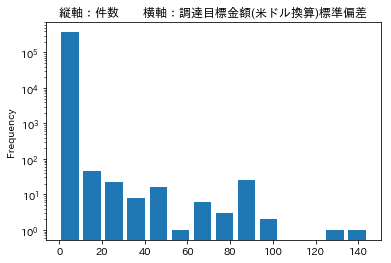

In [116]:
df_ksp["usd_goal_real_std"].plot(kind="hist", rwidth=.8, logy=True, bins=14,
                                 title="縦軸：件数　　横軸：調達目標金額(米ドル換算)標準偏差")

In [117]:
df_ksp[df_ksp["usd_goal_real_std"] > 90]

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,...,deadline_Y,deadline_m,deadline_Ym,count,deadline_Ymf,launched_Y,launched_m,launched_Ym,launched_Ymf,usd_goal_real_std
47803,1243678698,FUCK Potato Salad. Paleo Potato Brownies!,Food,Food,GBP,2014-08-08,99000000.0,2014-07-09 00:24:34,0.0,False,...,2014,08,2014-08,1,2014.666667,2014,07,2014-07,2014.583333,144.409142
196531,2000749004,A Celtic Lovestory,Drama,Film & Video,GBP,2015-11-30,100000000.0,2015-11-17 00:47:15,0.0,False,...,2015,11,2015-11,1,2015.916667,2015,11,2015-11,2015.916667,131.414827
222208,2132015082,DER NEANDERTALER (Kinofilm mit Starbesetzung i...,Movie Theaters,Film & Video,EUR,2017-03-14,100000000.0,2017-01-13 20:08:41,36.0,False,...,2017,03,2017-03,1,2017.250000,2017,01,2017-01,2017.083333,93.187774
226161,219702078,Kitchen from Austria in Switzerland,Restaurants,Food,CHF,2015-10-05,100000000.0,2015-08-06 19:12:10,0.0,False,...,2015,10,2015-10,1,2015.833333,2015,08,2015-08,2015.666667,90.311430
367928,944541075,Hydroponic's Skyscraper(un gratte-ciel hydropo...,Technology,Technology,EUR,2015-10-24,100000000.0,2015-08-25 23:52:30,2.0,False,...,2015,10,2015-10,1,2015.833333,2015,08,2015-08,2015.666667,95.618884


## 3.4.14.3 成功したプロジェクトのusd_goal_real_stdの分布

In [118]:
successful = df_ksp.loc[df_ksp["state"]]

In [119]:
successful["usd_goal_real_std"].describe()

count    133851.000000
mean         -0.031434
std           0.024283
min          -0.039714
25%          -0.038585
50%          -0.036380
75%          -0.031031
max           1.710406
Name: usd_goal_real_std, dtype: float64

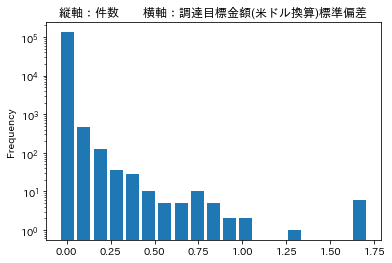

In [120]:
successful["usd_goal_real_std"].plot(kind="hist", rwidth=0.8, logy=True, bins=19,
                                 title="縦軸：件数　　横軸：調達目標金額(米ドル換算)標準偏差")

In [121]:
successful["usd_goal_real"].describe()

count    1.338510e+05
mean     9.535702e+03
std      2.796708e+04
min      1.000000e-02
25%      1.300000e+03
50%      3.840000e+03
75%      1.000000e+04
max      2.015609e+06
Name: usd_goal_real, dtype: float64

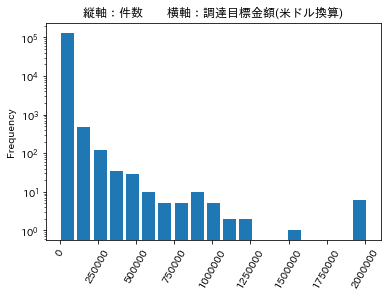

In [122]:
successful["usd_goal_real"].plot(kind="hist", rwidth=0.8, logy=True, bins=19, rot=60,
                                 title="縦軸：件数　　横軸：調達目標金額(米ドル換算)")

## 4 項目間の関係

## 4.1 main_categoryとcategoryの関係
(1) ほとんどのcategoryは、ひとつのmain_categoryに属する。  
(2) 以下に示す例外は、合計6464件であり、全体372062件の1.7%に過ぎない。  
  - 予測にmain_categoryを用い、categoryは用いないこととする。  

|categry     |main_category                                             |合計件数|
|------------|----------------------------------------------------------|--------|
|Anthologies |Comics(402)、Publishing(373)                              |775     |
|Comedy      |Film & Video(2104)、Music(18)、Publishing(72)、Theater(96)|2290    |
|Events      |Comics(161)、Food(651)                                    |812     |
|Experimental|Film & Video(547)、Theater(370)                           |917     |
|Festivals   |Film & Video(289)、Theater(547)                           |836     |
|Spaces      |Dance(198)、Food(424)、Theater(212)                       |834     |
|　          |合計                                                      |6464    |


In [123]:
(402+373+2104+18+72+96+161+651+547+370+289+547+198+424+212)/372062

0.017373448511269627

In [124]:
pd.get_option("display.max_rows")

60

In [125]:
pd.set_option('display.max_rows', 160)

In [126]:
pd.crosstab(df_ksp["category"], df_ksp["main_category"])

main_category,Art,Comics,Crafts,Dance,Design,Fashion,Film & Video,Food,Games,Journalism,Music,Photography,Publishing,Technology,Theater
category,,,,,,,,,,,,,,,
3D Printing,0,0,0,0,0,0,0,0,0,0,0,0,0,674,0
Academic,0,0,0,0,0,0,0,0,0,0,0,0,905,0,0
Accessories,0,0,0,0,0,3109,0,0,0,0,0,0,0,0,0
Action,0,0,0,0,0,0,733,0,0,0,0,0,0,0,0
Animals,0,0,0,0,0,0,0,0,0,0,0,252,0,0,0
Animation,0,0,0,0,0,0,2525,0,0,0,0,0,0,0,0
Anthologies,0,402,0,0,0,0,0,0,0,0,0,0,373,0,0
Apparel,0,0,0,0,0,7056,0,0,0,0,0,0,0,0,0
Apps,0,0,0,0,0,0,0,0,0,0,0,0,0,6266,0


In [127]:
pd.set_option('display.max_rows', 60)

## 4.2 currencyとcountryの関係
(1) country毎のcurrencyは1意に決まるため、currencyのみを予測に用いることにする。

In [128]:
pd.crosstab(df_ksp["country"], df_ksp["currency"])

currency,AUD,CAD,CHF,DKK,EUR,GBP,HKD,JPY,MXN,NOK,NZD,SEK,SGD,USD
country,,,,,,,,,,,,,,
AT,0,0,0,0,582,0,0,0,0,0,0,0,0,0
AU,7769,0,0,0,0,0,0,0,0,0,0,0,0,0
BE,0,0,0,0,605,0,0,0,0,0,0,0,0,0
CA,0,14624,0,0,0,0,0,0,0,0,0,0,0,0
CH,0,0,746,0,0,0,0,0,0,0,0,0,0,0
DE,0,0,0,0,4096,0,0,0,0,0,0,0,0,0
DK,0,0,0,1097,0,0,0,0,0,0,0,0,0,0
ES,0,0,0,0,2224,0,0,0,0,0,0,0,0,0
FR,0,0,0,0,2887,0,0,0,0,0,0,0,0,0


## 4.3 資金調達期間 period = deadline(締切日付) - launched(開始日時)
(1) 資金調達期間は、最小が0日、25%値と50%値が29日、75%値が35日、最大が91日であった。ほとんどは1か月、長くても3か月である。  
(2) periodの分布は、成功したプロジェクトの方が短期間が多いという傾向が若干あるが、予測には用いないことにした。  

In [129]:
df_ksp["period"] = (df_ksp["deadline"] - df_ksp["launched"]).dt.days.astype(float)

In [130]:
df_ksp.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,...,deadline_m,deadline_Ym,count,deadline_Ymf,launched_Y,launched_m,launched_Ym,launched_Ymf,usd_goal_real_std,period
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,False,...,10,2015-10,1,2015.833333,2015,08,2015-08,2015.666667,-0.038382,58.0
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,False,...,11,2017-11,1,2017.916667,2017,09,2017-09,2017.750000,-0.013665,59.0
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,False,...,02,2013-02,1,2013.166667,2013,01,2013-01,2013.083333,-0.000641,44.0
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,False,...,04,2012-04,1,2012.333333,2012,03,2012-03,2012.250000,-0.035372,29.0
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,False,...,08,2015-08,1,2015.666667,2015,07,2015-07,2015.583333,-0.022782,55.0


## 4.3.1 periodの種類

In [131]:
df_ksp["period"].describe()

count    372055.000000
mean         33.175141
std          12.793434
min           0.000000
25%          29.000000
50%          29.000000
75%          36.000000
max          91.000000
Name: period, dtype: float64

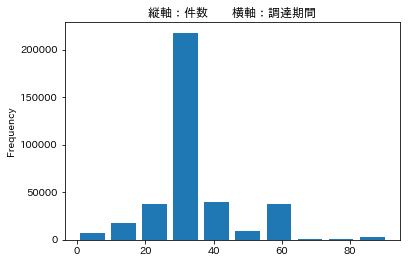

In [132]:
df_ksp["period"].plot(kind="hist", rwidth=0.8, title="縦軸：件数　　横軸：調達期間")

## 4.3.2 成功したプロジェクトのperiodの分布

In [133]:
successful = df_ksp.loc[df_ksp["state"]]

In [134]:
successful["period"].describe()

count    133851.000000
mean         31.156741
std          11.772298
min           0.000000
25%          29.000000
50%          29.000000
75%          33.000000
max          91.000000
Name: period, dtype: float64

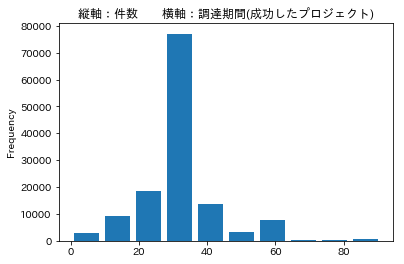

In [135]:
successful["period"].plot(kind="hist", rwidth=0.8, title="縦軸：件数　　横軸：調達期間(成功したプロジェクト)")

## 4.4 数値項目の相関関係

## 4.4.1 相関係数
(1) deadline_Ymfとlaunched_Ymfの間には強い相関があるため、予測にはdeadline_Ymfを用いることにする。launched_Ymfは用いない。  
(2) periodは、2012年ごろまでは約90日があったが、それ以降は長くても約60日となっている。  
(3) usd_goal_real_stdは、調達目標金額が低い場合は成功しているが、高くなると難しいことを示している。

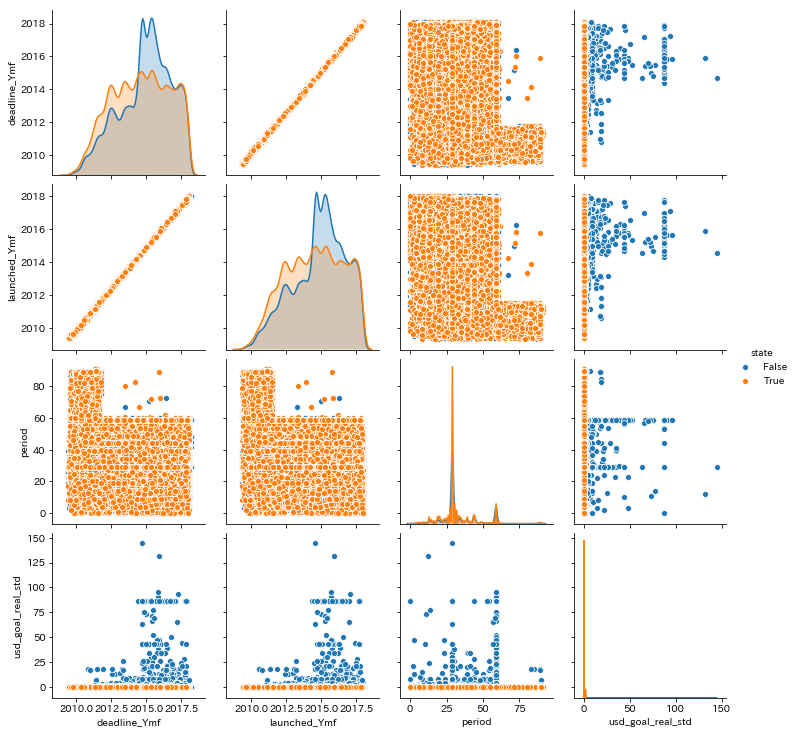

In [136]:
sns.pairplot(df_ksp[["state", "deadline_Ymf", "launched_Ymf", "period", "usd_goal_real_std"]], hue="state")

## 5. 予測に用いる情報の編集
(1) 今までの検討過程でdf_kspに生じたNanを含む行を削除する。  
(2) 以下の編集を行いdf_ksp2に収納する。  

|項目            |種類|内容                                |編集内容 |  
|----------------|----|------------------------------------|---------|  
|state	         |文字|プロジェクトの状態　目的変数■      |one-hot化|  
|main_category	 |文字|主なカテゴリー                      |one-hot化|  
|currency	     |通貨|使用された通貨                      |one-hot化|  
|usd_goal_real   |数値|目標調達金額の米ドル換算            |標準化   |  
|deadline_Ymf    |日付|deadlineの年月(年+月/12のfloat)     |標準化   |  
|period          |数値|deadline - launchedを示す日数(float)|そのまま |

## 5.1 df_kspからの欠損値を含む行の削除
(1) 欠損値を含む行はなかった。  
(2) 件数は372055件と、当初の378661件の98%である。  

In [137]:
df_ksp.isnull().sum()

ID                   0
name                 0
category             0
main_category        0
currency             0
deadline             0
goal                 0
launched             0
pledged              0
state                0
backers              0
country              0
usd pledged          0
usd_pledged_real     0
usd_goal_real        0
deadline_Y           0
deadline_m           0
deadline_Ym          0
count                0
deadline_Ymf         0
launched_Y           0
launched_m           0
launched_Ym          0
launched_Ymf         0
usd_goal_real_std    0
period               0
dtype: int64

In [138]:
df_ksp.describe()

,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real,count,deadline_Ymf,launched_Ymf,usd_goal_real_std,period
count,3.720550e+05,3.720550e+05,3.720550e+05,372055.000000,3.720550e+05,3.720550e+05,3.720550e+05,372055.0,372055.000000,372055.000000,3.720550e+05,372055.000000
mean,1.074584e+09,4.931883e+04,9.755701e+03,106.980393,7.080423e+03,9.145509e+03,4.573831e+04,1.0,2014.849667,2014.756044,4.423048e-17,33.175141
std,6.191881e+08,1.182585e+06,9.626656e+04,914.532666,7.893221e+04,9.162231e+04,1.151699e+06,0.0,1.911739,1.917959,1.000001e+00,12.793434
min,5.971000e+03,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02,1.0,2009.416667,2009.333333,-3.971381e-02,0.000000
25%,5.378127e+08,2.000000e+03,3.100000e+01,2.000000,1.800000e+01,3.125000e+01,2.000000e+03,1.0,2013.416667,2013.333333,-3.797725e-02,29.000000
50%,1.075308e+09,5.500000e+03,6.250000e+02,12.000000,4.000000e+02,6.279700e+02,5.500000e+03,1.0,2015.000000,2014.916667,-3.493826e-02,29.000000
75%,1.610138e+09,1.650000e+04,4.093000e+03,57.000000,3.057000e+03,4.066000e+03,1.600000e+04,1.0,2016.333333,2016.250000,-2.582128e-02,36.000000
max,2.147476e+09,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08,1.0,2018.166667,2018.083333,1.444091e+02,91.000000


In [139]:
372055 / 378661

0.9825543163938193

## 5.2 予測用df_ksp2の編集

## 5.2.1 state

In [140]:
df_ksp2 = pd.DataFrame(df_ksp["state"], dtype=bool)

## 5.2.2 main_category

In [141]:
df_dummy = pd.get_dummies(df_ksp["main_category"], dtype=bool)
df_ksp2 = pd.concat([df_ksp2, df_dummy], axis=1)

## 5.2.3 currency

In [142]:
df_dummy = pd.get_dummies(df_ksp["currency"], dtype=bool)
df_ksp2 = pd.concat([df_ksp2, df_dummy], axis=1)

## 5.2.4 usd_goal_real_std

In [143]:
df_ksp2 = pd.concat([df_ksp2, df_ksp["usd_goal_real"]], axis=1)

## 5.2.5 deadline_Ymf

In [144]:
df_ksp2 = pd.concat([df_ksp2, df_ksp["deadline_Ymf"]], axis=1)

## 5.2.6 period

In [145]:
df_ksp2 = pd.concat([df_ksp2, df_ksp["period"]], axis=1)

In [146]:
df_ksp2

,state,Art,Comics,Crafts,Dance,Design,Fashion,Film & Video,Food,Games,...,JPY,MXN,NOK,NZD,SEK,SGD,USD,usd_goal_real,deadline_Ymf,period
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,1533.95,2015.833333,58.0
1,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,True,30000.00,2017.916667,59.0
2,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,True,45000.00,2013.166667,44.0
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,5000.00,2012.333333,29.0
4,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,True,19500.00,2015.666667,55.0
5,True,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,True,50000.00,2016.333333,34.0
6,True,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,True,1000.00,2015.000000,19.0
7,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,True,25000.00,2016.250000,44.0
8,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,True,125000.00,2014.416667,34.0
9,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,True,65000.00,2014.666667,29.0


In [147]:
df_ksp2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 372055 entries, 0 to 378660
Data columns (total 33 columns):
state            372055 non-null bool
Art              372055 non-null bool
Comics           372055 non-null bool
Crafts           372055 non-null bool
Dance            372055 non-null bool
Design           372055 non-null bool
Fashion          372055 non-null bool
Film & Video     372055 non-null bool
Food             372055 non-null bool
Games            372055 non-null bool
Journalism       372055 non-null bool
Music            372055 non-null bool
Photography      372055 non-null bool
Publishing       372055 non-null bool
Technology       372055 non-null bool
Theater          372055 non-null bool
AUD              372055 non-null bool
CAD              372055 non-null bool
CHF              372055 non-null bool
DKK              372055 non-null bool
EUR              372055 non-null bool
GBP              372055 non-null bool
HKD              372055 non-null bool
JPY            

## 6. ロジスティック回帰

In [148]:
X = df_ksp2.drop("state", axis=1).values
y = df_ksp2["state"].values

## 6.1 ホールドアウト法

In [149]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1234)

In [150]:
# 学習
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, 
                    fit_intercept=True, random_state=1234, tol=1e-3)
clf.fit(X_train, y_train)

# テストデータに対する予測を実行
y_pred_test = clf.predict(X_test)

print('対数尤度 = {:.3f}  '.format(log_loss(y_test, y_pred_test)), end="")

print('正答率(accuracy)={:.3f}%  recall={:.3f}%  '.format(
    100 * accuracy_score(y_test, y_pred_test), 
    100 * recall_score(y_test, y_pred_test)), end="") 

print('precision={:.3f}%  f1={:.3f}%'.format(
    100 * precision_score(y_test, y_pred_test),
    100 * f1_score(y_test, y_pred_test)))

# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred_test), 
                        index=['正解 = 失敗', '正解 = 成功'], 
                        columns=['予測 = 失敗', '予測 = 成功'])
conf_mat

対数尤度 = 12.356  正答率(accuracy)=64.227%  recall=16.823%  precision=51.347%  f1=25.343%


,予測 = 失敗,予測 = 成功
正解 = 失敗,43274,4281
正解 = 成功,22338,4518


## 6.2 交差検証法

In [151]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1234)

In [152]:
n_splits = 5            # 5分割
split_num = 0           # 交差検証の回数を記憶する変数

log_loss_value  = 0     # log_loss
log_loss_sum    = 0     #   累積用変数
log_loss_mean   = 0     #   平均用変数
accuracy_value  = 0     # accuracy
accuracy_sum    = 0     #   累積用変数
accuracy_mean   = 0     #   平均用変数
recall_value    = 0     # recall
recall_sum      = 0     #   累積用変数
recall_mean     = 0     #   平均用変数
precision_value = 0     # precision
precision_sum   = 0     #   累積用変数
precision_mean  = 0     #   平均用変数
f1_value        = 0     # f1
f1_sum          = 0     #   累積用変数
f1_mean         = 0     #   平均用変数

# テスト役を交代させながら学習と評価を繰り返す
for train_idx, test_idx in KFold(
    n_splits=n_splits, shuffle=True, random_state=1234).split(X, y):

    X_train = X[train_idx]  # 学習用データ
    y_train = y[train_idx]  # 学習用データ
    X_test  = X[test_idx]   # テスト用データ
    y_test  = y[test_idx]   # テスト用データ
    
    # 学習
    clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, 
                        fit_intercept=True, random_state=1234, tol=1e-3)
    clf.fit(X_train, y_train)

    # テストデータに対する予測を実行
    y_pred_test = clf.predict(X_test)

    log_loss_value  = log_loss(y_test, y_pred_test)
    log_loss_sum   += log_loss_value
    accuracy_value  = accuracy_score(y_test, y_pred_test)
    accuracy_sum   += accuracy_value
    recall_value    = recall_score(  y_test, y_pred_test)
    recall_sum     += recall_value
    precision_value = precision_score(y_test, y_pred_test)
    precision_sum  += precision_value
    f1_value        = f1_score(       y_test, y_pred_test)
    f1_sum         += f1_value

    print('対数尤度={:.3f}  '.format(log_loss_value), end="")

    print('正答率(accuracy)={:.3f}%  recall={:.3f}%  '.format(
        100 * accuracy_value, 100 * recall_value), end="") 

    print('precision={:.3f}%  f1={:.3f}%'.format(
        100 * precision_value, 100 * f1_value))
    
    # 予測値と正解のクロス集計
    conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred_test), 
                            index=['正解 = 失敗', '正解 = 成功'], 
                            columns=['予測 = 失敗', '予測 = 成功'])
    display(conf_mat)
    
    split_num += 1

log_loss_mean  = log_loss_sum  / split_num
accuracy_mean  = accuracy_sum  / split_num
recall_mean    = recall_sum    / split_num
precision_mean = precision_sum / split_num
f1_mean        = f1_sum        / split_num
          
print('【平均】対数尤度={:.3f}  '.format(log_loss_mean), end="")

print('正答率(accuracy)={:.3f}%  recall={:.3f}%  '.format(
    100 * accuracy_mean, 100 * recall_mean), end="") 

print('precision={:.3f}%  f1={:.3f}%'.format(
    100 * precision_mean, 100 * f1_mean))

対数尤度=13.382  正答率(accuracy)=61.254%  recall=53.738%  precision=46.798%  f1=50.029%


,予測 = 失敗,予測 = 成功
正解 = 失敗,31148,16407
正解 = 成功,12424,14432


対数尤度=12.363  正答率(accuracy)=64.207%  recall=13.829%  precision=51.385%  f1=21.794%


,予測 = 失敗,予測 = 成功
正解 = 失敗,44066,3511
正解 = 成功,23123,3711


対数尤度=12.388  正答率(accuracy)=64.132%  recall=0.815%  precision=58.919%  f1=1.607%


,予測 = 失敗,予測 = 成功
正解 = 失敗,47503,152
正解 = 成功,26538,218


対数尤度=16.063  正答率(accuracy)=53.493%  recall=69.152%  precision=41.135%  f1=51.585%


,予測 = 失敗,予測 = 成功
正解 = 失敗,21369,26382
正解 = 成功,8224,18436


対数尤度=13.255  正答率(accuracy)=61.623%  recall=48.529%  precision=46.737%  f1=47.616%


,予測 = 失敗,予測 = 成功
正解 = 失敗,32875,14791
正解 = 成功,13766,12979


【平均】対数尤度=13.490  正答率(accuracy)=60.942%  recall=37.213%  precision=48.995%  f1=34.526%


## 6.3 特徴選択 (Lasso法)

In [153]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1234)

In [154]:
# LassoCVを使って、正則化の強さを自動決定したモデル（estimator）を作成
estimator = LassoCV(normalize=True, cv=10)

# モデルの情報を使って特徴選択を行うためSelectFromModelを使う
# 今回は係数がしきい値（threshold）が1e-5以下である特徴を削除する
sfm = SelectFromModel(estimator, threshold=1e-5)

# fitで特徴選択を実行
sfm.fit(X_train, y_train)

SelectFromModel(estimator=LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=None, normalize=True,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False),
        max_features=None, norm_order=1, prefit=False, threshold=1e-05)

In [155]:
# get_support関数で使用する特徴のインデックスを使用
# Trueになっている特徴が使用する特徴
sfm.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True])

In [156]:
# 削除すべき特徴の名前を取得 
removed_idx  = ~sfm.get_support()
df_X = pd.DataFrame(df_ksp2.drop("state", axis=1))
df_X.columns[removed_idx]

Index(['Games', 'usd_goal_real'], dtype='object')

In [157]:
# LASSOで得た各特徴の係数の値を確認してみよう
# 係数の絶対値を取得
abs_coef = np.abs(sfm.estimator_.coef_)
abs_coef

array([3.97133627e-02, 1.76474857e-01, 1.21352630e-01, 2.47007854e-01,
       4.06785853e-03, 1.10065760e-01, 9.65380217e-03, 1.08881522e-01,
       0.00000000e+00, 1.43184492e-01, 1.20922708e-01, 5.90190661e-02,
       4.77277304e-02, 1.35855597e-01, 2.23656190e-01, 6.57731151e-02,
       4.81226613e-02, 2.48429528e-02, 8.88153405e-03, 7.33071046e-02,
       3.59398400e-04, 5.45687654e-02, 3.90034532e-02, 7.56807110e-02,
       1.09212807e-01, 1.64497386e-02, 3.35955897e-02, 4.20528066e-02,
       4.68639405e-03, 7.23429224e-09, 1.39983083e-02, 4.80064298e-03])

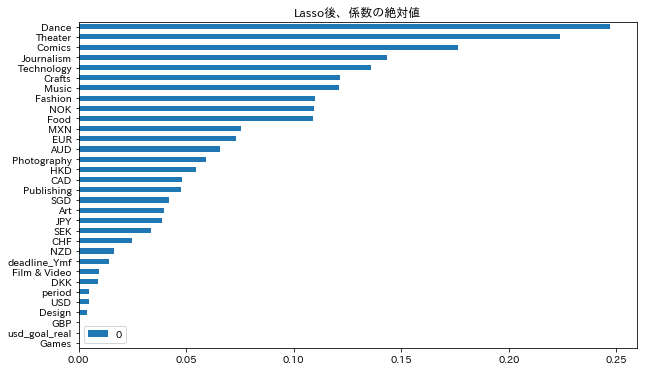

In [158]:
# 係数を棒グラフで表示
df_coef = pd.DataFrame([abs_coef], columns=df_X.columns.values).T
df_coef.sort_values(by=0).plot(kind="barh", figsize=(10,6), title="Lasso後、係数の絶対値")

## 6.4 特徴選択 (ラッパー法)

In [159]:
estimator = SGDClassifier(loss="log", penalty="none", fit_intercept=True)
rfecv = RFECV(estimator, cv=10, scoring="accuracy")
y = df_ksp2["state"].values
X = df_ksp2.drop("state", axis=1).values
rfecv.fit(X, y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=

RFECV(cv=10,
   estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='none',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
   min_features_to_select=1, n_jobs=None, scoring='accuracy', step=1,
   verbose=0)

Feature ranking: 
[ 1  1  2 11  1  4  1  8  1  1  1  9  1 10  1 12  1 17 19  1  7 18 21 14
 15 13 16 20  1  6  5  3]


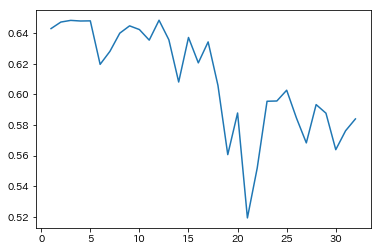

In [160]:
print("Feature ranking: \n{}".format(rfecv.ranking_))
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [161]:
remove_idx = ~rfecv.support_

In [162]:
remove_feature = df_ksp2.drop("state", axis=1).columns[remove_idx]

## 6.4.1 削除する特徴量

In [163]:
remove_feature

Index(['Crafts', 'Dance', 'Fashion', 'Food', 'Photography', 'Technology',
       'AUD', 'CHF', 'DKK', 'GBP', 'HKD', 'JPY', 'MXN', 'NOK', 'NZD', 'SEK',
       'SGD', 'usd_goal_real', 'deadline_Ymf', 'period'],
      dtype='object')

## 6.4.2 特徴選択後の予測用df_ksp3の編集

In [164]:
df_ksp3 = df_ksp2.drop(remove_feature, axis=1)
df_ksp3

,state,Art,Comics,Design,Film & Video,Games,Journalism,Music,Publishing,Theater,CAD,EUR,USD
0,False,False,False,False,False,False,False,False,True,False,False,False,False
1,False,False,False,False,True,False,False,False,False,False,False,False,True
2,False,False,False,False,True,False,False,False,False,False,False,False,True
3,False,False,False,False,False,False,False,True,False,False,False,False,True
4,False,False,False,False,True,False,False,False,False,False,False,False,True
5,True,False,False,False,False,False,False,False,False,False,False,False,True
6,True,False,False,False,False,False,False,False,False,False,False,False,True
7,False,False,False,False,False,False,False,False,False,False,False,False,True
8,False,False,False,True,False,False,False,False,False,False,False,False,True
9,False,False,False,False,True,False,False,False,False,False,False,False,True


In [165]:
X = df_ksp3.drop("state", axis=1).values
y = df_ksp3["state"].values

## 6.5 ホールドアウト法 (特徴量削除後)

In [166]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1234)

In [167]:
# 学習
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, 
                    fit_intercept=True, random_state=1234, tol=1e-3)
clf.fit(X_train, y_train)

# テストデータに対する予測を実行
y_pred_test = clf.predict(X_test)

print('対数尤度 = {:.3f}  '.format(log_loss(y_test, y_pred_test)), end="")

print('正答率(accuracy)={:.3f}%  recall={:.3f}%  '.format(
    100 * accuracy_score(y_test, y_pred_test), 
    100 * recall_score(y_test, y_pred_test)), end="") 

print('precision={:.3f}%  f1={:.3f}%'.format(
    100 * precision_score(y_test, y_pred_test),
    100 * f1_score(y_test, y_pred_test)))

# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred_test), 
                        index=['正解 = 失敗', '正解 = 成功'], 
                        columns=['予測 = 失敗', '予測 = 成功'])
conf_mat

対数尤度 = 12.143  正答率(accuracy)=64.844%  recall=25.030%  precision=52.730%  f1=33.946%


,予測 = 失敗,予測 = 成功
正解 = 失敗,41529,6026
正解 = 成功,20134,6722


## 7. SVM(線形カーネル)

In [168]:
X = df_ksp2.drop("state", axis=1).values
y = df_ksp2["state"].values

## 7.1 ホールドアウト法 ➡ 計算が終わらない

In [169]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1234)

In [170]:
"""
# 学習
C = 10
clf = SVC(C=C, kernel="linear", random_state=1234)
clf.fit(X_train, y_train) 

# テストデータに対する予測を実行
y_pred_test = clf.predict(X_test)

print('対数尤度 = {:.3f}  '.format(log_loss(y_test, y_pred_test)), end="")

print('正答率(accuracy)={:.3f}%  recall={:.3f}%  '.format(
    100 * accuracy_score(y_test, y_pred_test), 
    100 * recall_score(y_test, y_pred_test)), end="") 

print('precision={:.3f}%  f1={:.3f}%'.format(
    100 * precision_score(y_test, y_pred_test),
    100 * f1_score(y_test, y_pred_test)))

# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred_test), 
                        index=['正解 = 失敗', '正解 = 成功'], 
                        columns=['予測 = 失敗', '予測 = 成功'])
conf_mat
"""

'\n# 学習\nC = 10\nclf = SVC(C=C, kernel="linear", random_state=1234)\nclf.fit(X_train, y_train) \n\n# テストデータに対する予測を実行\ny_pred_test = clf.predict(X_test)\n\nprint(\'対数尤度 = {:.3f}  \'.format(log_loss(y_test, y_pred_test)), end="")\n\nprint(\'正答率(accuracy)={:.3f}%  recall={:.3f}%  \'.format(\n    100 * accuracy_score(y_test, y_pred_test), \n    100 * recall_score(y_test, y_pred_test)), end="") \n\nprint(\'precision={:.3f}%  f1={:.3f}%\'.format(\n    100 * precision_score(y_test, y_pred_test),\n    100 * f1_score(y_test, y_pred_test)))\n\n# 予測値と正解のクロス集計\nconf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred_test), \n                        index=[\'正解 = 失敗\', \'正解 = 成功\'], \n                        columns=[\'予測 = 失敗\', \'予測 = 成功\'])\nconf_mat\n'

## 8. SVM (ガウスカーネル)

In [171]:
X = df_ksp2.drop("state", axis=1).values
y = df_ksp2["state"].values

## 8.1 ホールドアウト法 ➡ 計算が終わらない

In [172]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1234)

In [173]:
"""
# SVMの実行
C = 5
kernel = "rbf"
gamma = 1
clf = SVC(C=C, kernel=kernel, gamma=gamma)
clf.fit(X_train, y_train)

# 未知のデータを識別する
print(clf.predict(X_test))

print('対数尤度 = {:.3f}  '.format(log_loss(y_test, y_pred_test)), end="")

print('正答率(accuracy)={:.3f}%  recall={:.3f}%  '.format(
    100 * accuracy_score(y_test, y_pred_test), 
    100 * recall_score(y_test, y_pred_test)), end="") 

print('precision={:.3f}%  f1={:.3f}%'.format(
    100 * precision_score(y_test, y_pred_test),
    100 * f1_score(y_test, y_pred_test)))

# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred_test), 
                        index=['正解 = 失敗', '正解 = 成功'], 
                        columns=['予測 = 失敗', '予測 = 成功'])
conf_mat
"""

'\n# SVMの実行\nC = 5\nkernel = "rbf"\ngamma = 1\nclf = SVC(C=C, kernel=kernel, gamma=gamma)\nclf.fit(X_train, y_train)\n\n# 未知のデータを識別する\nprint(clf.predict(X_test))\n\nprint(\'対数尤度 = {:.3f}  \'.format(log_loss(y_test, y_pred_test)), end="")\n\nprint(\'正答率(accuracy)={:.3f}%  recall={:.3f}%  \'.format(\n    100 * accuracy_score(y_test, y_pred_test), \n    100 * recall_score(y_test, y_pred_test)), end="") \n\nprint(\'precision={:.3f}%  f1={:.3f}%\'.format(\n    100 * precision_score(y_test, y_pred_test),\n    100 * f1_score(y_test, y_pred_test)))\n\n# 予測値と正解のクロス集計\nconf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred_test), \n                        index=[\'正解 = 失敗\', \'正解 = 成功\'], \n                        columns=[\'予測 = 失敗\', \'予測 = 成功\'])\nconf_mat\n'

## 9. 決定木

In [174]:
X = df_ksp2.drop("state", axis=1).values
y = df_ksp2["state"].values

## 9.1 ホールドアウト法

In [175]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1234)

In [176]:
# 学習
clf = DecisionTreeClassifier(random_state=1234)
clf = clf.fit(X_train, y_train)

# テストデータに対する予測を実行
y_pred_test = clf.predict(X_test)

print('対数尤度 = {:.3f}  '.format(log_loss(y_test, y_pred_test)), end="")

print('正答率(accuracy)={:.3f}%  recall={:.3f}%  '.format(
    100 * accuracy_score(y_test, y_pred_test), 
    100 * recall_score(y_test, y_pred_test)), end="") 

print('precision={:.3f}%  f1={:.3f}%'.format(
    100 * precision_score(y_test, y_pred_test),
    100 * f1_score(y_test, y_pred_test)))

# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred_test), 
                        index=['正解 = 失敗', '正解 = 成功'], 
                        columns=['予測 = 失敗', '予測 = 成功'])
conf_mat

対数尤度 = 12.947  正答率(accuracy)=62.516%  recall=42.739%  precision=47.841%  f1=45.146%


,予測 = 失敗,予測 = 成功
正解 = 失敗,35041,12514
正解 = 成功,15378,11478


## 9.2 特徴選択 (ラッパー法)

In [177]:
estimator = DecisionTreeClassifier(random_state=1234)
rfecv = RFECV(estimator, cv=10, scoring="accuracy")
y = df_ksp2["state"].values
X = df_ksp2.drop("state", axis=1).values
rfecv.fit(X, y)

RFECV(cv=10,
   estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1234,
            splitter='best'),
   min_features_to_select=1, n_jobs=None, scoring='accuracy', step=1,
   verbose=0)

Feature ranking: 
[ 4 13 20 21  7 12  3  9  6 22 11 17  5 10 16 19 15 28 25 18 14 27 31 26
 29 24 23 30  8  1  1  2]


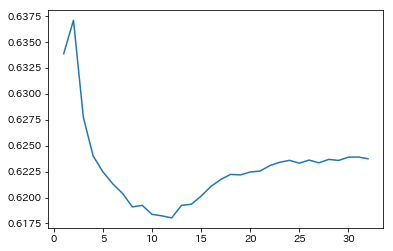

In [178]:
print("Feature ranking: \n{}".format(rfecv.ranking_))
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [179]:
remove_idx = ~rfecv.support_

In [180]:
remove_feature = df_ksp2.drop("state", axis=1).columns[remove_idx]

## 9.2.1 削除する特徴量

In [181]:
remove_feature

Index(['Art', 'Comics', 'Crafts', 'Dance', 'Design', 'Fashion', 'Film & Video',
       'Food', 'Games', 'Journalism', 'Music', 'Photography', 'Publishing',
       'Technology', 'Theater', 'AUD', 'CAD', 'CHF', 'DKK', 'EUR', 'GBP',
       'HKD', 'JPY', 'MXN', 'NOK', 'NZD', 'SEK', 'SGD', 'USD', 'period'],
      dtype='object')

## 9.2.2 特徴選択後の予測用df_ksp3の編集

In [182]:
df_ksp3 = df_ksp2.drop(remove_feature, axis=1)
df_ksp3

,state,usd_goal_real,deadline_Ymf
0,False,1533.95,2015.833333
1,False,30000.00,2017.916667
2,False,45000.00,2013.166667
3,False,5000.00,2012.333333
4,False,19500.00,2015.666667
5,True,50000.00,2016.333333
6,True,1000.00,2015.000000
7,False,25000.00,2016.250000
8,False,125000.00,2014.416667
9,False,65000.00,2014.666667


In [183]:
X = df_ksp3.drop("state", axis=1).values
y = df_ksp3["state"].values

## 9.3 ホールドアウト法 (特徴量削除後)

In [184]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1234)

In [185]:
# 学習
clf = DecisionTreeClassifier(random_state=1234)
clf.fit(X_train, y_train)

# テストデータに対する予測を実行
y_pred_test = clf.predict(X_test)

print('対数尤度 = {:.3f}  '.format(log_loss(y_test, y_pred_test)), end="")

print('正答率(accuracy)={:.3f}%  recall={:.3f}%  '.format(
    100 * accuracy_score(y_test, y_pred_test), 
    100 * recall_score(y_test, y_pred_test)), end="") 

print('precision={:.3f}%  f1={:.3f}%'.format(
    100 * precision_score(y_test, y_pred_test),
    100 * f1_score(y_test, y_pred_test)))

# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred_test), 
                        index=['正解 = 失敗', '正解 = 成功'], 
                        columns=['予測 = 失敗', '予測 = 成功'])
conf_mat

対数尤度 = 12.533  正答率(accuracy)=63.712%  recall=30.381%  precision=49.557%  f1=37.669%


,予測 = 失敗,予測 = 成功
正解 = 失敗,39250,8305
正解 = 成功,18697,8159


## 10. ランダムフォレスト

In [186]:
X = df_ksp2.drop("state", axis=1).values
y = df_ksp2["state"].values

## 10.1 ホールドアウト法

In [187]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1234)

In [188]:
# 学習
clf = RandomForestClassifier(random_state=1234)
clf.fit(X_train, y_train)

# テストデータに対する予測を実行
y_pred_test = clf.predict(X_test)

print('対数尤度 = {:.3f}  '.format(log_loss(y_test, y_pred_test)), end="")

print('正答率(accuracy)={:.3f}%  recall={:.3f}%  '.format(
    100 * accuracy_score(y_test, y_pred_test), 
    100 * recall_score(y_test, y_pred_test)), end="") 

print('precision={:.3f}%  f1={:.3f}%'.format(
    100 * precision_score(y_test, y_pred_test),
    100 * f1_score(y_test, y_pred_test)))

# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred_test), 
                        index=['正解 = 失敗', '正解 = 成功'], 
                        columns=['予測 = 失敗', '予測 = 成功'])
conf_mat

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


対数尤度 = 12.305  正答率(accuracy)=64.374%  recall=40.702%  precision=50.804%  f1=45.196%


,予測 = 失敗,予測 = 成功
正解 = 失敗,36970,10585
正解 = 成功,15925,10931


## 10.2 特徴選択 (ラッパー法)

In [189]:
estimator = RandomForestClassifier(random_state=1234)
rfecv = RFECV(estimator, cv=10, scoring="accuracy")
y = df_ksp2["state"].values
X = df_ksp2.drop("state", axis=1).values
rfecv.fit(X, y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: F

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: F

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: F

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: F

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: F

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: F

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: F

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: F

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: F

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RFECV(cv=10,
   estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=1234, verbose=0,
            warm_start=False),
   min_features_to_select=1, n_jobs=None, scoring='accuracy', step=1,
   verbose=0)

Feature ranking: 
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 4 1 1 1 1 3 1 1 1 1]


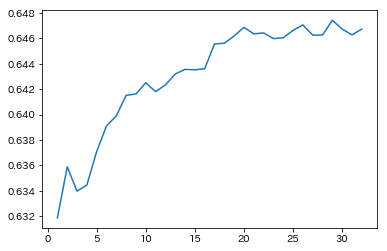

In [190]:
print("Feature ranking: \n{}".format(rfecv.ranking_))
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [191]:
remove_idx = ~rfecv.support_

In [192]:
remove_feature = df_ksp2.drop("state", axis=1).columns[remove_idx]

## 10.2.1 削除する特徴量

In [193]:
remove_feature

Index(['HKD', 'JPY', 'SGD'], dtype='object')

## 10.2.2 特徴選択後の予測用df_ksp3の編集

In [194]:
df_ksp3 = df_ksp2.drop(remove_feature, axis=1)
df_ksp3

,state,Art,Comics,Crafts,Dance,Design,Fashion,Film & Video,Food,Games,...,EUR,GBP,MXN,NOK,NZD,SEK,USD,usd_goal_real,deadline_Ymf,period
0,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,1533.95,2015.833333,58.0
1,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,True,30000.00,2017.916667,59.0
2,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,True,45000.00,2013.166667,44.0
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,5000.00,2012.333333,29.0
4,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,True,19500.00,2015.666667,55.0
5,True,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,True,50000.00,2016.333333,34.0
6,True,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,True,1000.00,2015.000000,19.0
7,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,True,25000.00,2016.250000,44.0
8,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,True,125000.00,2014.416667,34.0
9,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,True,65000.00,2014.666667,29.0


In [195]:
X = df_ksp3.drop("state", axis=1).values
y = df_ksp3["state"].values

## 10.3 ホールドアウト法 (特徴量削除後)

In [196]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1234)

In [197]:
# 学習
clf = RandomForestClassifier(random_state=1234)
clf.fit(X_train, y_train)

# テストデータに対する予測を実行
y_pred_test = clf.predict(X_test)

print('対数尤度 = {:.3f}  '.format(log_loss(y_test, y_pred_test)), end="")

print('正答率(accuracy)={:.3f}%  recall={:.3f}%  '.format(
    100 * accuracy_score(y_test, y_pred_test), 
    100 * recall_score(y_test, y_pred_test)), end="") 

print('precision={:.3f}%  f1={:.3f}%'.format(
    100 * precision_score(y_test, y_pred_test),
    100 * f1_score(y_test, y_pred_test)))

# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred_test), 
                        index=['正解 = 失敗', '正解 = 成功'], 
                        columns=['予測 = 失敗', '予測 = 成功'])
conf_mat

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


対数尤度 = 12.296  正答率(accuracy)=64.400%  recall=40.706%  precision=50.851%  f1=45.217%


,予測 = 失敗,予測 = 成功
正解 = 失敗,36989,10566
正解 = 成功,15924,10932


## 11. アダブースト

In [198]:
X = df_ksp2.drop("state", axis=1).values
y = df_ksp2["state"].values

## 11.1 ホールドアウト法

In [199]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1234)

In [200]:
# 学習
clf = AdaBoostClassifier(DecisionTreeClassifier(random_state=1234))
clf.fit(X_train, y_train)

# テストデータに対する予測を実行
y_pred_test = clf.predict(X_test)

print('対数尤度 = {:.3f}  '.format(log_loss(y_test, y_pred_test)), end="")

print('正答率(accuracy)={:.3f}%  recall={:.3f}%  '.format(
    100 * accuracy_score(y_test, y_pred_test), 
    100 * recall_score(y_test, y_pred_test)), end="") 

print('precision={:.3f}%  f1={:.3f}%'.format(
    100 * precision_score(y_test, y_pred_test),
    100 * f1_score(y_test, y_pred_test)))

# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred_test), 
                        index=['正解 = 失敗', '正解 = 成功'], 
                        columns=['予測 = 失敗', '予測 = 成功'])
conf_mat

対数尤度 = 12.660  正答率(accuracy)=63.347%  recall=43.316%  precision=49.118%  f1=46.035%


,予測 = 失敗,予測 = 成功
正解 = 失敗,35504,12051
正解 = 成功,15223,11633


## 11.2 特徴選択 (ラッパー法)

In [201]:
estimator = AdaBoostClassifier(DecisionTreeClassifier(random_state=1234))
rfecv = RFECV(estimator, cv=10, scoring="accuracy")
y = df_ksp2["state"].values
X = df_ksp2.drop("state", axis=1).values
rfecv.fit(X, y)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [202]:
df_ksp2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 372055 entries, 0 to 378660
Data columns (total 33 columns):
state            372055 non-null bool
Art              372055 non-null bool
Comics           372055 non-null bool
Crafts           372055 non-null bool
Dance            372055 non-null bool
Design           372055 non-null bool
Fashion          372055 non-null bool
Film & Video     372055 non-null bool
Food             372055 non-null bool
Games            372055 non-null bool
Journalism       372055 non-null bool
Music            372055 non-null bool
Photography      372055 non-null bool
Publishing       372055 non-null bool
Technology       372055 non-null bool
Theater          372055 non-null bool
AUD              372055 non-null bool
CAD              372055 non-null bool
CHF              372055 non-null bool
DKK              372055 non-null bool
EUR              372055 non-null bool
GBP              372055 non-null bool
HKD              372055 non-null bool
JPY            

In [ ]:
print("Feature ranking: \n{}".format(rfecv.ranking_))
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [ ]:
remove_idx = ~rfecv.support_

In [ ]:
remove_feature = df_ksp2.drop("state", axis=1).columns[remove_idx]

## 11.2.1 削除する特徴量

In [ ]:
remove_feature

## 11.2.2 特徴選択後の予測用df_ksp3の編集

In [ ]:
df_ksp3 = df_ksp2.drop(remove_feature, axis=1)
df_ksp3

In [ ]:
X = df_ksp3.drop("state", axis=1).values
y = df_ksp3["state"].values

## 11.3 ホールドアウト法 (特徴量削除後)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1234)

In [ ]:
# 学習
clf = AdaBoostClassifier(DecisionTreeClassifier(random_state=1234))
clf.fit(X_train, y_train)

# テストデータに対する予測を実行
y_pred_test = clf.predict(X_test)

print('対数尤度 = {:.3f}  '.format(log_loss(y_test, y_pred_test)), end="")

print('正答率(accuracy)={:.3f}%  recall={:.3f}%  '.format(
    100 * accuracy_score(y_test, y_pred_test), 
    100 * recall_score(y_test, y_pred_test)), end="") 

print('precision={:.3f}%  f1={:.3f}%'.format(
    100 * precision_score(y_test, y_pred_test),
    100 * f1_score(y_test, y_pred_test)))

# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred_test), 
                        index=['正解 = 失敗', '正解 = 成功'], 
                        columns=['予測 = 失敗', '予測 = 成功'])
conf_mat

## 12. 結果のまとめ

## 12.1 ロジスティック回帰のホールドアウト法と交差検証法の比較
(1) accuracyの最大値はNo.6.1(ホールドアウト法)の64.227%であった。  
(2) 予想に反してホールドアウト法よりも交差検証法の方がaccuracyの値が低かった。原因は偶然と考える。  

|No |モデル             |特徴選択(ラッパー法)|方式           |対数尤度|accuracy|recall |precision|f1     |備考                |  
|---|-------------------|--------------------|---------------|--------|--------|-------|---------|-------|--------------------|  
|6.1|ロジスティック回帰 |なし                |ホールドアウト |12.356  |64.227% |16.823%|51.347%  |25.343%|-                   |  
|6.2|ロジスティック回帰 |あり  　            |交差検証(1回目)|13.382  |61.254% |53.738%|46.798%  |50.029%|-                   |  
|6.2|ロジスティック回帰 |あり  　            |交差検証(2回目)|12.363  |64.207% |13.829%|51.385%  |21.794%|-                   |  
|6.2|ロジスティック回帰 |あり  　            |交差検証(3回目)|12.388  |64.132% |0.815% |58.919%  | 1.607%|-                   |  
|6.2|ロジスティック回帰 |あり  　            |交差検証(4回目)|16.063  |53.493% |69.152%|41.135%  |51.585%|-                   |  
|6.2|ロジスティック回帰 |あり  　            |交差検証(5回目)|13.255  |61.623% |48.529%|46.737%  |47.616%|-                   |  
|6.2|ロジスティック回帰 |あり  　            |交差検証(平均 )|13.490  |60.942% |37.213%|48.995%  |34.526%|-                   |  

## 12.2 モデルの比較
(1) accuracyの最大値は、No.6.5(ホールドアウト法・特徴選択あり)の64.844%であった。特徴選択の効果があったと考える。  
(2) SVMは計算が終わらなかった。(コンピュータがだんまりを続けたため諦めた) 【質問】どこまで動いているか見る方法がありますか?  
(3) 決定木のaccuracyは、No.9.1が62.516%、No.9.2が63.712%とロジスティック回帰よりも低かった。  
(4) ランダムフォレストのaccuracyは、No.10.1が64.374%、No.10.2が64.400%であり、ロジスティック回帰と同程度であった。  
(5) アダブーストのaccuracyは、特徴選択なしで63.347%であり、ロジスティック回帰よりも低かった。  
(6) アダブーストでの特徴選択は、計算が途中で止まった。時間切れで調べることができなかった。  

|No. |モデル             |特徴選択(ラッパー法)|対数尤度|accuracy|recall |precision|f1     |備考                |  
|----|-------------------|--------------------|--------|--------|-------|---------|-------|--------------------|  
| 6.1|ロジスティック回帰 |なし  　            |12.356  |64.227% |16.823%|51.347%  |25.343%|-                   |  
| 6.5|ロジスティック回帰 |あり                |12.143  |64.844% |25.030%|57.730%  |33.946%|-                   |  
| 7.1|SVM(線形カーネル)  |- 　　　            |-       |-       |-      |-        |-      |計算が終わらなかった|  
| 8.2|SVM(ガウスカーネル)|-   　　            |-       |-       |-      |-        |-      |計算が終わらなかった|  
| 9.1|決定木             |なし  　            |12.947  |62.516% |42.739%|47.841%  |45.146%|-                   |  
| 9.3|決定木             |あり  　            |12.533  |63.712% |30.381%|49.557%  |37.669%|-                   |   
|10.1|ランダムフォレスト |なし  　            |12.305  |64.374% |40.702%|50.804%  |45.196%|-                   |  
|10.3|ランダムフォレスト |あり  　            |12.296  |64.400% |40.706%|50.851%  |45.217%|-                   |  
|11.1|アダブースト       |なし  　            |12.660  |63.347% |43.316%|49.118%  |46.035%|-                   |　
|11.3|アダブースト       |あり  　            |-       |-       |-      |-        |-      |計算が途中で止まった|  

## 12.3 特徴量の選択
(1) No.6.5のロジスティック回帰の特徴量に、"usd_goal_real"と"deadline_Ymf"が除外されたことが意外であった。  
　　accuracyは向上したので、意味ある特徴量選択であったと考える。  
(2) No.10.3のランダムフォレストの特徴量選択グラフの形がおかしかった。時間切れで検討ができなかった。  

|No. |モデル             |特徴量                                                                                         |備考|  
|----|-------------------|-----------------------------------------------------------------------------------------------|----|  
| 6.5|ロジスティック回帰 |Art, Comics, Design, Film & Video, Games, Journalism, Music, Publishing, Theater, CAD, EUR, USD|-   |  
| 9.3|決定木             |usd_goal_real, deadline_Ymf                                                                    |-   |  
|10.3|ランダムフォレスト |【'HKD', 'JPY', 'SGD'以外全て】Art, Comics, Crafts, ... usd_goal_real, deadline_Ymf, period    |グラフがおかしい|  
|11.3|アダブースト       |-                                                                                  |計算できなかった|  
